# 1. Introduction 📝

This notebook documents a proof-of-concept (PoC) project designed to evaluate and compare modern and traditional Natural Language Processing (NLP) models for a multi-class text classification task. The primary objective is to build a robust classifier for Wikipedia articles from the **DBPedia dataset**, categorizing them based on a hierarchical ontology.

The project follows a structured, real-world methodology:
1.  **Exploratory Data Analysis (EDA):** A thorough analysis of the dataset to understand class distributions, text characteristics, and potential challenges.
2.  **Baseline Modeling:** Establishing performance benchmarks using a traditional **TF-IDF + Logistic Regression** model and a lightweight Transformer, **DistilBERT**.
3.  **Advanced Model Evaluation:** Implementing and fine-tuning a state-of-the-art model, **ModernBERT**, to assess its performance lift over the baselines.
4.  **Deployment Adaptation:** Recognizing and adapting to real-world deployment constraints, such as container size limits, by selecting the most practical model for production.

This notebook serves as a comprehensive record of the experimentation process, from data preprocessing and model training to results analysis and final model selection for deployment. All experiments are tracked using **MLflow** to ensure reproducibility and systematic comparison.

# 2. EDA and Preprocessing 📊

## Imports

In [1]:
# Google drive setup
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Github repository cloning
from google.colab import userdata # Import the userdata module
GIT_TOKEN = userdata.get('GITHUB_TOKEN') # Or use secrets manager in Colab
GIT_USERNAME = "M-Carre"
GIT_REPO = "OC-NeoBERT-POC"
REPO_NAME = "OC-NeoBERT-POC"

# --- Clean up ---
%cd /content
# Remove the existing repository directory if it exists
# The -rf flags mean recursive (delete subdirectories) and force (suppress prompts)
!rm -rf {REPO_NAME}
print(f"Removed existing directory ./{REPO_NAME} (if it existed).")

# Git clone
!git clone https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPO}.git

# It's good practice to navigate into your repository directory
%cd OC-NeoBERT-POC

/content
Removed existing directory ./OC-NeoBERT-POC (if it existed).
Cloning into 'OC-NeoBERT-POC'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 7.39 KiB | 7.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/OC-NeoBERT-POC


In [3]:
# Configure Git user for this session
# This helps identify your commits correctly
!git config --global user.email "carre.mathis@proton.me"
!git config --global user.name "M-Carre"

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import shutil # For copying files
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing with spaCy
import spacy
# You might need to download the English model if you haven't already
# Run in a new cell: !python -m spacy download en_core_web_sm
# Then load it:
# nlp = spacy.load('en_core_web_sm')

# Scikit-learn for traditional ML tasks and metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Mlflow to track our metrics, artifacts and models
!pip install mlflow -q
import mlflow
import mlflow.sklearn
import mlflow.pytorch # For PyTorch autologging or manual logging

# PyTorch for deep learning tasks
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.optim as optim 
from tqdm.notebook import tqdm # For progress bars
import torch.nn as nn
from transformers import AutoModelForSequenceClassification 
import joblib


# Hugging Face Transformers (will be used more heavily in later phases)
# import transformers # We can import specific modules later as needed

# Other utilities
import re # For regular expressions, if needed for cleaning
import collections # For Counter, if used for frequency distributions

# Plotting settings (optional, for aesthetics)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 19.9 MB/s eta 0:00:00


In [ ]:
# Copy dataset from Drive to local (cloned) project directory and load it

# --- Configuration ---
# Path to the dataset on your Google Drive
drive_dataset_path = '/content/drive/MyDrive/Colab Notebooks/OC/P9/Data/DBP_wiki_data.csv'

# Relative path where you want to store the dataset within your cloned project
# Example: Create a 'data' folder inside your 'OC-NeoBERT-POC' repository
local_project_data_folder = 'data' # This folder will be inside OC-NeoBERT-POC
local_dataset_filename = 'DBP_wiki_data.csv'
local_dataset_path = os.path.join(local_project_data_folder, local_dataset_filename)

# --- Ensure local data directory exists ---
# This assumes you are already in the root of your cloned repository (e.g., /content/OC-NeoBERT-POC)
if not os.path.exists(local_project_data_folder):
    os.makedirs(local_project_data_folder)
    print(f"Created local directory: {local_project_data_folder}")

# --- Copy the file from Drive to the local project directory ---
try:
    shutil.copy(drive_dataset_path, local_dataset_path)
    print(f"Dataset copied from Google Drive to: {local_dataset_path}")
except FileNotFoundError:
    print(f"ERROR: Source file not found on Google Drive at {drive_dataset_path}")
    print("Please ensure the file exists and the path is correct.")
except Exception as e:
    print(f"An error occurred while copying the file: {e}")

# --- Load the dataset using the local relative path ---
if os.path.exists(local_dataset_path):
    try:
        df = pd.read_csv(local_dataset_path)
        print("Dataset loaded successfully from local project path!")
        print(f"Shape of the dataset: {df.shape}")
        print("First 5 rows of the dataset:")
        print(df.head())
    except Exception as e:
        print(f"An error occurred while loading the dataset from {local_dataset_path}: {e}")
else:
    print(f"ERROR: Dataset not found at local project path {local_dataset_path} after attempting copy.")
    df = None # Initialize df as None if loading fails

Created local directory: data
Dataset copied from Google Drive to: data/DBP_wiki_data.csv
Dataset loaded successfully from local project path!
Shape of the dataset: (342781, 6)
First 5 rows of the dataset:
                                                text     l1            l2  \
0  The 1994 Mindoro earthquake occurred on Novemb...  Event  NaturalEvent   
1  The 1917 Bali earthquake occurred at 06:50 loc...  Event  NaturalEvent   
2  The 1941 Colima earthquake occurred on April 1...  Event  NaturalEvent   
3  The 1983 Coalinga earthquake occurred on May 2...  Event  NaturalEvent   
4  The 2013 Bushehr earthquake occurred with a mo...  Event  NaturalEvent   

           l3                 wiki_name  word_count  
0  Earthquake   1994_Mindoro_earthquake          59  
1  Earthquake      1917_Bali_earthquake          68  
2  Earthquake    1941_Colima_earthquake         194  
3  Earthquake  1983_Coalinga_earthquake          98  
4  Earthquake   2013_Bushehr_earthquake          61  


## EDA

### Uncleaned data

Let's start with a basic data inspection

In [ ]:
# 1. Basic DataFrame Inspection
print("--- Basic DataFrame Inspection ---")
if 'df' in globals() and df is not None:
    print("Shape of the DataFrame:")
    print(df.shape) # (Number of rows, Number of columns)

    print("\nColumn names and data types:")
    print(df.info())

    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())

    print("\nLast 5 rows of the DataFrame:")
    print(df.tail())

    print("\nSummary statistics for numerical columns (if any):")
    # The 'Number of words in item text' column should be numerical
    print(df.describe())

    print("\nSummary statistics for all columns (including categorical):")
    print(df.describe(include='all'))
else:
    print("DataFrame 'df' is not loaded. Please ensure the data loading cell was executed successfully.")

--- Basic DataFrame Inspection ---
Shape of the DataFrame:
(342781, 6)

Column names and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342781 entries, 0 to 342780
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        342781 non-null  object
 1   l1          342781 non-null  object
 2   l2          342781 non-null  object
 3   l3          342781 non-null  object
 4   wiki_name   342781 non-null  object
 5   word_count  342781 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 15.7+ MB
None

First 5 rows of the DataFrame:
                                                text     l1            l2  \
0  The 1994 Mindoro earthquake occurred on Novemb...  Event  NaturalEvent   
1  The 1917 Bali earthquake occurred at 06:50 loc...  Event  NaturalEvent   
2  The 1941 Colima earthquake occurred on April 1...  Event  NaturalEvent   
3  The 1983 Coalinga earthquake occurred on May 2...  Event  Natu

1.  **Shape & Completeness:**
    *   The dataset contains 342,781 entries and 6 columns.
    *   Crucially, there are *no missing values* across all columns, simplifying preprocessing.

2.  **Data Types:**
    *   Columns `text`, `l1`, `l2`, `l3`, and `wiki_name` are `object` type (strings), which is appropriate for textual and categorical data.
    *   `word_count` is `int64`, suitable for numerical counts.

3.  **Content Preview (`.head()`):**
    *   The first few rows show examples primarily from the 'Event' -> 'NaturalEvent' -> 'Earthquake' hierarchy, illustrating the dataset's structure.
    *   `wiki_name` appears to be a unique identifier derived from the Wikipedia article title.

4.  **Numerical Summary (`word_count`):**
    *   Mean word count is ~106, while the median (50th percentile) is 74. This difference suggests a right-skewed distribution (a few very long articles).
    *   The range is significant: from 2 to 732 words. This will be important for setting sequence lengths in Transformer models.

5.  **Categorical Summary (`describe(include='all')`):**
    *   `text` and `wiki_name` have unique values for each entry, as expected.
    *   **`l1` (Target Variable):**
        *   9 unique classes.
        *   'Agent' is the most frequent class, appearing 177,341 times.
    *   `l2`: 70 unique classes, 'Athlete' is most frequent.
    *   `l3`: 219 unique classes, 'FootballMatch' is most frequent. The increasing number of unique classes down the hierarchy is logical.

Let's go on with some visuals


--- Analyzing 'word_count' Distribution ---


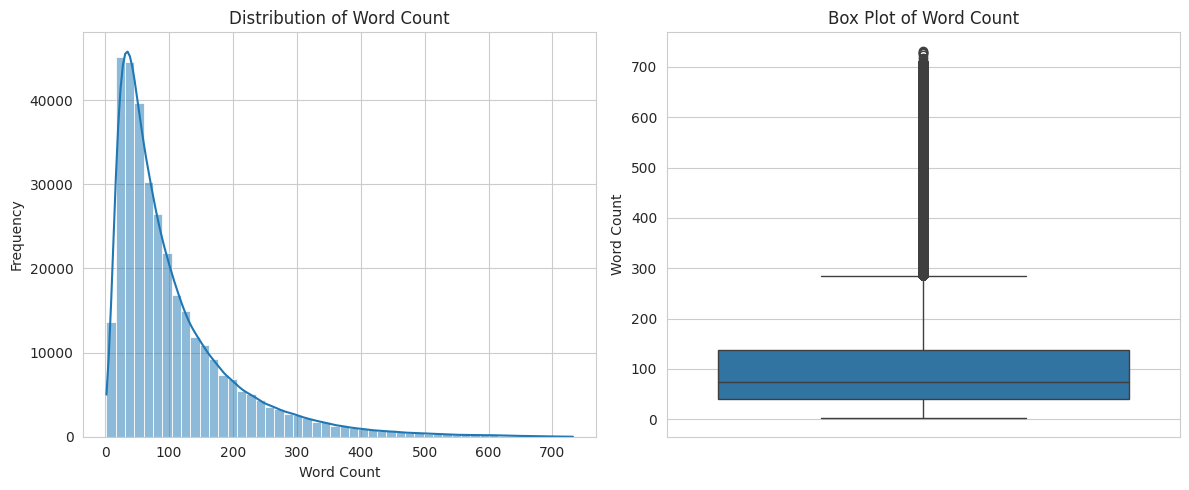

Skewness of word_count: 2.03

--- Analyzing Distribution of Level 1 Categories ('l1') ---


/tmp/ipython-input-7-1742699749.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l1_counts.index, y=l1_counts.values, palette="viridis")


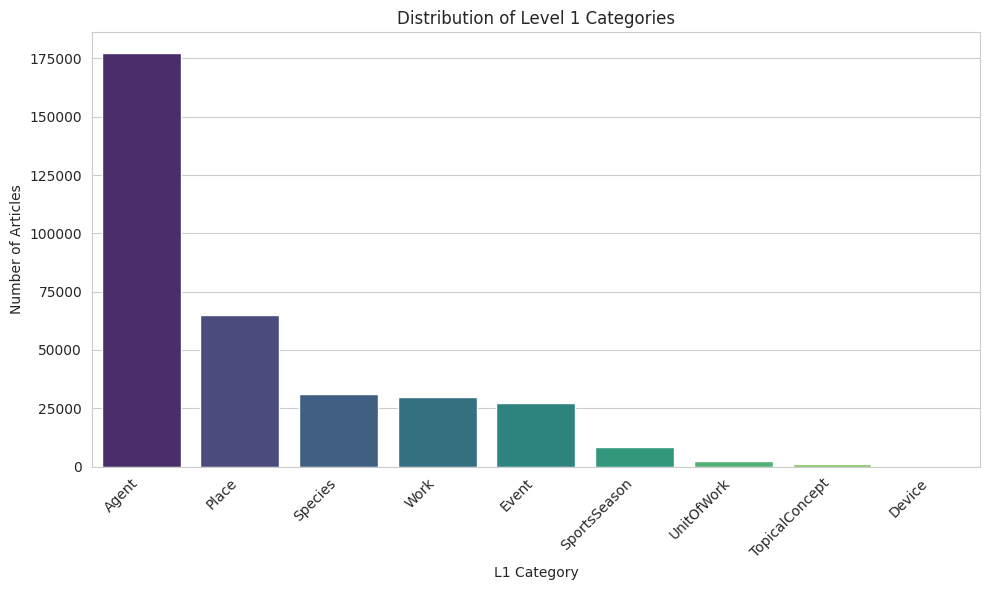


Value counts for 'l1':
l1
Agent             177341
Place              65128
Species            31149
Work               29832
Event              27059
SportsSeason        8307
UnitOfWork          2497
TopicalConcept      1115
Device               353
Name: count, dtype: int64

Proportions for 'l1':
l1
Agent             51.735948
Place             18.999886
Species            9.087143
Work               8.702933
Event              7.893961
SportsSeason       2.423413
UnitOfWork         0.728453
TopicalConcept     0.325281
Device             0.102981
Name: proportion, dtype: float64


In [ ]:
# 2. Visual Analysis of 'word_count'
print("\n--- Analyzing 'word_count' Distribution ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['word_count'])
plt.title('Box Plot of Word Count')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

print(f"Skewness of word_count: {df['word_count'].skew():.2f}")
# A skewness > 1 or < -1 often indicates a highly skewed distribution.
# A skewness between 0.5 and 1 (or -0.5 and -1) is moderately skewed.
# A skewness between -0.5 and 0.5 is fairly symmetrical.

# 3. Visual Analysis of Target Variable 'l1'
print("\n--- Analyzing Distribution of Level 1 Categories ('l1') ---")
plt.figure(figsize=(10, 6))
l1_counts = df['l1'].value_counts()
sns.barplot(x=l1_counts.index, y=l1_counts.values, palette="viridis")
plt.title('Distribution of Level 1 Categories')
plt.xlabel('L1 Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

print("\nValue counts for 'l1':")
print(l1_counts)
print("\nProportions for 'l1':")
print(df['l1'].value_counts(normalize=True) * 100)


1.  **`word_count` Distribution:**
    *   The histogram and boxplot confirm a *strong right-skew* for `word_count`, with a calculated skewness of **2.03**.
    *   Most articles are relatively short (median 74 words, 75th percentile at 138 words), but there's a long tail of much longer articles (up to 732 words).
    *   *Implication:* For Transformer models, a common sequence length like 256 or 512 would cover the majority of articles without excessive truncation. The impact of truncating longer articles needs to be considered. NeoBERT's longer context window (4096) might be beneficial for these outliers if they contain critical information towards the end.

2.  **`l1` Category Distribution:**
    *   The bar plot clearly shows an **imbalanced class distribution** for our primary target variable, `l1`.
    *   **'Agent'** is the dominant class, accounting for approximately **51.7%** of the dataset.
    *   'Place' is the second most common (around 19.0%).
    *   Classes like 'SportsSeason', 'UnitOfWork', 'TopicalConcept', and especially 'Device' are significantly underrepresented (e.g., 'Device' is only ~0.1%).
    *   *Implication:*
        *   Accuracy alone might be a misleading evaluation metric. We should prioritize metrics like **weighted/macro F1-score, precision, and recall** for a more comprehensive assessment.
        *   The model might become biased towards predicting the majority class ('Agent').
        *   Consider strategies during modeling if performance on minority classes is poor: class weighting in the loss function, or more advanced techniques like over/under-sampling (though often less critical for large Transformer models if the minority classes still have a decent absolute number of samples).

Let's have a look at targets 'l2' and 'l3'


--- Analyzing Distribution of Level 2 Categories ('l2') ---
Number of unique L2 categories: 70

Top 15 L2 categories:
l2
Athlete                  44163
Person                   27892
Animal                   21333
Building                 15266
Politician               13514
Company                  11777
Organisation             10137
MusicalWork               9903
WinterSportPlayer         8972
SocietalEvent             8608
RouteOfTransportation     8359
PeriodicalLiterature      8089
SportsTeam                7968
NaturalPlace              7766
Artist                    7091
Name: count, dtype: int64


/tmp/ipython-input-8-1237881102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l2_counts.head(top_n_l2).index, y=l2_counts.head(top_n_l2).values, palette="mako")


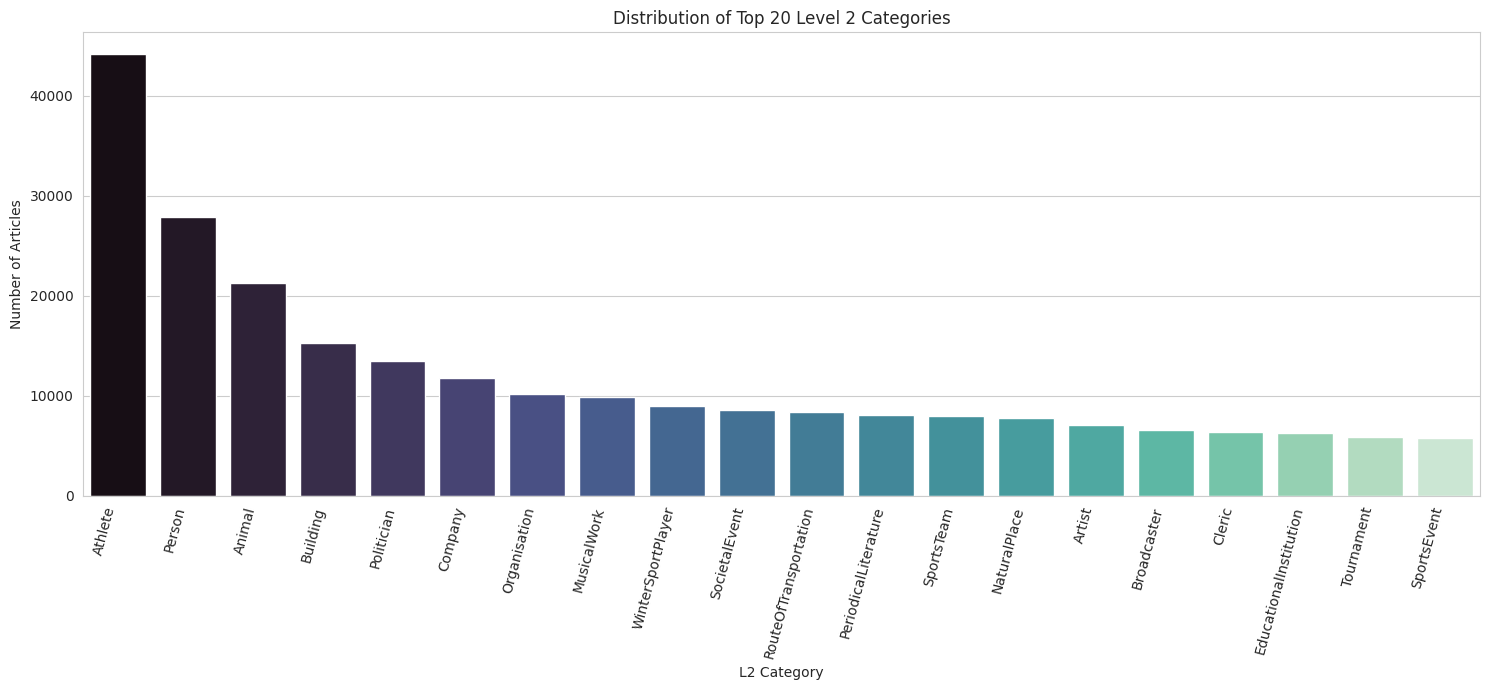


--- Analyzing Distribution of Level 3 Categories ('l3') ---
Number of unique L3 categories: 219

Top 15 L3 categories:
l3
FootballMatch       2700
Manga               2700
AcademicJournal     2700
GolfPlayer          2700
Planet              2700
VideoGame           2699
Mollusca            2699
Amphibian           2699
SoccerTournament    2699
Dam                 2699
Stadium             2699
OlympicEvent        2699
Fungus              2698
RailwayLine         2698
Airport             2698
Name: count, dtype: int64


/tmp/ipython-input-8-1237881102.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l3_counts.head(top_n_l3).index, y=l3_counts.head(top_n_l3).values, palette="rocket")


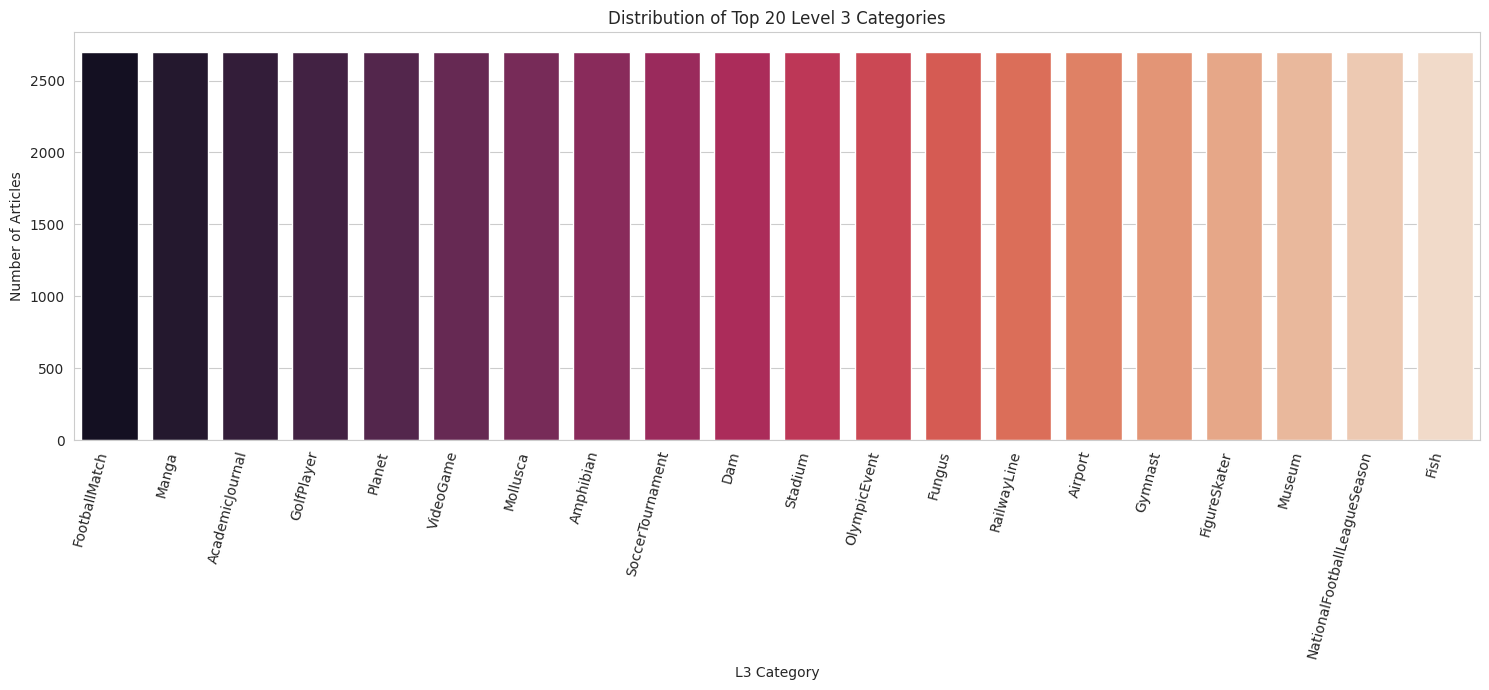

In [ ]:
# 4. Analysis of Level 2 ('l2') and Level 3 ('l3') Categories
print("\n--- Analyzing Distribution of Level 2 Categories ('l2') ---")
l2_counts = df['l2'].value_counts()
print("Number of unique L2 categories:", len(l2_counts))
print("\nTop 15 L2 categories:")
print(l2_counts.head(15)) # Display top 15 for brevity as there are 70

plt.figure(figsize=(15, 7)) # Increased figure size for more categories
# Plotting only top N for better visualization if there are too many
top_n_l2 = 20
sns.barplot(x=l2_counts.head(top_n_l2).index, y=l2_counts.head(top_n_l2).values, palette="mako")
plt.title(f'Distribution of Top {top_n_l2} Level 2 Categories')
plt.xlabel('L2 Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Analyzing Distribution of Level 3 Categories ('l3') ---")
l3_counts = df['l3'].value_counts()
print("Number of unique L3 categories:", len(l3_counts))
print("\nTop 15 L3 categories:")
print(l3_counts.head(15)) # Display top 15 for brevity as there are 219

plt.figure(figsize=(15, 7)) # Increased figure size
top_n_l3 = 20
sns.barplot(x=l3_counts.head(top_n_l3).index, y=l3_counts.head(top_n_l3).values, palette="rocket")
plt.title(f'Distribution of Top {top_n_l3} Level 3 Categories')
plt.xlabel('L3 Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

1. **Level 2 Categories (l2):**

      There are 70 unique L2 categories.

      The distribution shows a clear skew, with "Athlete" being the most frequent L2 category (44,163 occurrences), followed by "Person" (27,892) and "Animal" (21,333).

      The top L2 categories are generally broad and represent common high-level classifications within the DBPedia ontology. The counts drop off, indicating a long tail of less frequent L2 categories.

2. **Level 3 Categories (l3):**

      There are 219 unique L3 categories, indicating a much finer level of granularity.

      A notable pattern in the top 15 L3 categories is that many have very similar counts, hovering around 2,700 (e.g., "FootballMatch", "Manga", "AcademicJournal", "GolfPlayer", "Planet" all at 2,700; "VideoGame", "Mollusca", etc., at 2,699).

      This near-uniform count for the most frequent L3 categories might suggest a dataset construction or sampling strategy that aimed for a target number of examples per L3 class, at least for a subset of them.

      The L3 categories are, as expected, much more specific than L1 or L2.

It could be very interesting to see if the word_count column is related to our l1 target...

--- Multivariate Analysis: Word Count vs. L1 Category ---


/tmp/ipython-input-10-1934183212.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


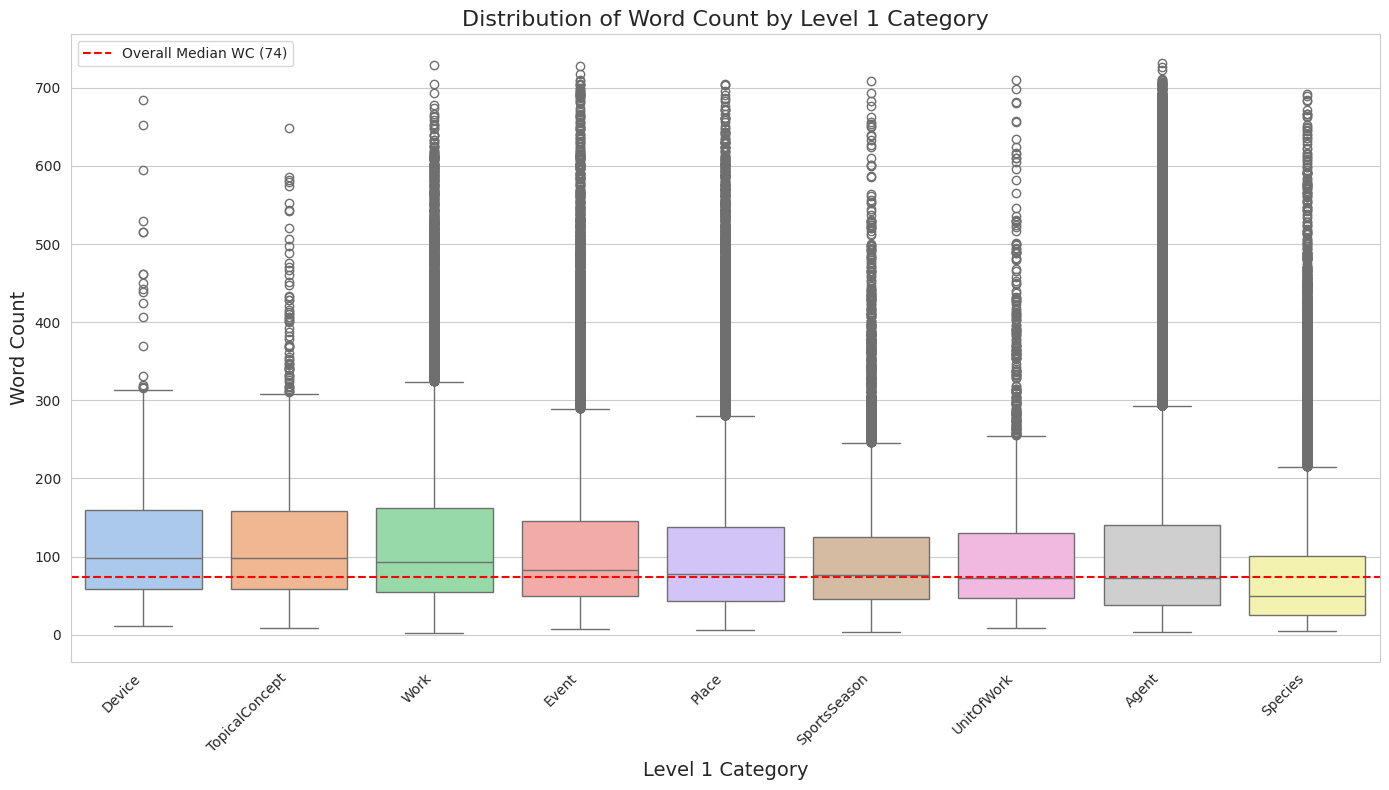


--- Summary statistics of 'word_count' grouped by 'l1' ---
                      mean  median         std  min  max   count
l1                                                              
Device          125.005666    98.0  105.380641   11  685     353
TopicalConcept  125.516592    98.0   99.502210    8  649    1115
Work            123.208836    93.0   99.322433    2  729   29832
Event           114.999889    83.0   98.980962    7  728   27059
Place           104.153682    77.0   88.060972    6  705   65128
SportsSeason    101.486337    76.0   86.580885    3  709    8307
UnitOfWork      108.208650    73.0   99.503479    9  710    2497
Agent           106.443834    72.0   99.896170    3  732  177341
Species          77.921763    49.0   80.333210    5  692   31149


In [ ]:
# Ensure 'df' is loaded and contains 'l1' and 'word_count'
if 'df' not in globals() or df is None or 'l1' not in df.columns or 'word_count' not in df.columns:
    print("DataFrame 'df' or required columns ('l1', 'word_count') not found.")
    print("Please ensure the data loading and previous EDA steps were successful.")
else:
    print("--- Multivariate Analysis: Word Count vs. L1 Category ---")

    plt.figure(figsize=(14, 8)) # Adjusted for better readability of x-axis labels

    # Create the boxplot
    # We order by median word_count to make the plot more informative
    order = df.groupby('l1')['word_count'].median().sort_values(ascending=False).index

    sns.boxplot(
        x='l1',
        y='word_count',
        data=df,
        palette="pastel", # Using a different palette
        order=order       # Order categories by median word count
    )

    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.title('Distribution of Word Count by Level 1 Category', fontsize=16)
    plt.xlabel('Level 1 Category', fontsize=14)
    plt.ylabel('Word Count', fontsize=14)

    # Add a line for the overall median word count for reference
    overall_median_word_count = df['word_count'].median()
    plt.axhline(overall_median_word_count, color='r', linestyle='--', linewidth=1.5, label=f'Overall Median WC ({overall_median_word_count:.0f})')
    plt.legend()

    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # Display summary statistics of word_count grouped by l1
    print("\n--- Summary statistics of 'word_count' grouped by 'l1' ---")
    word_count_by_l1_stats = df.groupby('l1')['word_count'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).sort_values(by='median', ascending=False)
    print(word_count_by_l1_stats)

- "**Device**" and "**TopicalConcept**" articles tend to be the longest in median terms (median word count of 98 for both), though their mean is also high (around 125 words). "Work" follows closely with a median of 93 words.

- "**Species**" articles are notably the shortest on average, with a median word count of only 49 and a mean of approximately 78. This makes intuitive sense, as descriptions of species might be more concise and factual compared to, for example, a "Work" (which could be a book, film, etc., often requiring more descriptive text).

- "**Agent**" articles, despite being the most numerous category, have a relatively low median word count (72 words), placing them towards the shorter end of the L1 categories. This is interesting given their prevalence.

- "**Event**", "**Place**", and "**SportsSeason**" articles fall in the mid-range regarding their median text lengths (medians of 83, 77, and 76 respectively).

**Variability (std):** Most categories show considerable standard deviations, often close to their mean values. This indicates a wide spread in article lengths within each category, which is also reflected in the large differences between min and max word counts for each. "Device" and "Agent" have some of the highest standard deviations.

Now let's create some functions to clean and lemmatize text

In [ ]:
# --- SpaCy Model Loading ---
try:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    print("spaCy 'en_core_web_sm' model loaded successfully (or was already loaded).")
except OSError:
    print("spaCy 'en_core_web_sm' model not found. Please run: !python -m spacy download en_core_web_sm")
    nlp = None

# --- Text Cleaning Function (Transformer-Friendly - NO LOWERCASING) ---
def transformer_friendly_cleaning(text):
    """
    Applies minimal cleaning suitable for (cased) Transformer models:
    1. Removes bracketed content like [edit], [1], [citation needed].
    2. Removes URLs.
    3. Removes HTML tags.
    4. Normalizes whitespace.
    DOES NOT CONVERT TO LOWERCASE.
    """
    text = str(text) # Ensure it's a string
    text = re.sub(r'\[.*?\]', '', text) # Remove bracketed content
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    return text

# --- Lemmatization Function for TF-IDF/EDA (INCLUDES LOWERCASING) ---
def lemmatize_for_tfidf_eda(text, remove_stopwords=True, remove_punct=True, keep_only_alpha=True):
    """
    Cleans, lowercases, and lemmatizes text using spaCy, suitable for TF-IDF or EDA.
    1. Lowercases the text.
    2. Applies spaCy NLP pipeline.
    3. Extracts lemmas.
    4. Optionally removes stopwords.
    5. Optionally removes punctuation tokens.
    6. Optionally keeps only alphabetic tokens.
    """
    if nlp is None:
        print("spaCy nlp model not loaded. Cannot lemmatize.")
        return "" # Return empty string or original text

    # Lowercase before processing with spaCy for consistent lemmatization and stopword removal
    text_to_process = str(text).lower()
    doc = nlp(text_to_process)

    lemmas = []
    for token in doc:
        # Determine if the token should be kept
        passes_filter = True
        if remove_stopwords and token.is_stop:
            passes_filter = False
        if remove_punct and token.is_punct:
            passes_filter = False
        if token.is_space: # Always skip space tokens
            passes_filter = False
        if keep_only_alpha and not token.is_alpha: # If true, only keeps purely alphabetic tokens
            passes_filter = False

        if passes_filter:
            lemmas.append(token.lemma_)

    return " ".join(lemmas)

# --- Let's test these functions ---
if nlp:
    sample_text_wiki = "The 1994 Mindoro earthquake occurred on November 15 [1] at 03:15 local time near Mindoro, the PHILIPPINES... It had studies & Running very fast! Visit https://example.com.  Extra   Spaces."

    print("--- Testing Transformer-Friendly Cleaning (No Lowercasing) ---")
    cleaned_for_transformer = transformer_friendly_cleaning(sample_text_wiki)
    print(f"Original:                 '{sample_text_wiki}'")
    print(f"Transformer-Friendly Cleaned: '{cleaned_for_transformer}'")

    print("\n--- Testing Lemmatization for TF-IDF/EDA (Includes Lowercasing) ---")
    # Using the raw sample text as input, as the function handles lowercasing
    lemmatized_for_eda = lemmatize_for_tfidf_eda(sample_text_wiki)
    print(f"Original:                 '{sample_text_wiki}'")
    print(f"Lemmatized for TF-IDF/EDA: '{lemmatized_for_eda}'")

    lemmatized_for_eda_keep_stops = lemmatize_for_tfidf_eda(sample_text_wiki, remove_stopwords=False)
    print(f"Lemmatized (keep stops):  '{lemmatized_for_eda_keep_stops}'")

    lemmatized_for_eda_flexible_alpha = lemmatize_for_tfidf_eda(sample_text_wiki, keep_only_alpha=False)
    print(f"Lemmatized (not only alpha):'{lemmatized_for_eda_flexible_alpha}'")
else:
    print("Cannot run tests as spaCy nlp model is not loaded.")

spaCy 'en_core_web_sm' model loaded successfully (or was already loaded).
--- Testing Transformer-Friendly Cleaning (No Lowercasing) ---
Original:                 'The 1994 Mindoro earthquake occurred on November 15 [1] at 03:15 local time near Mindoro, the PHILIPPINES... It had studies & Running very fast! Visit https://example.com.  Extra   Spaces.'
Transformer-Friendly Cleaned: 'The 1994 Mindoro earthquake occurred on November 15 at 03:15 local time near Mindoro, the PHILIPPINES... It had studies & Running very fast! Visit Extra Spaces.'

--- Testing Lemmatization for TF-IDF/EDA (Includes Lowercasing) ---
Original:                 'The 1994 Mindoro earthquake occurred on November 15 [1] at 03:15 local time near Mindoro, the PHILIPPINES... It had studies & Running very fast! Visit https://example.com.  Extra   Spaces.'
Lemmatized for TF-IDF/EDA: 'mindoro earthquake occur november local time near mindoro philippine study run fast visit extra space'
Lemmatized (keep stops):  'the mindo

We then apply those functions on our dataframe and save the new data

In [ ]:
# --- Apply preprocessing to create new columns ---

if 'df' in globals() and df is not None and nlp is not None:
    print("--- Applying 'transformer_friendly_cleaning' to create 'text_transformer' column ---")
    # This can take time on the full dataset
    df['text_transformer'] = df['text'].apply(transformer_friendly_cleaning)
    print("'text_transformer' column created.")
    print("Example:")
    print("Original:", df['text'].iloc[0][:150])
    print("Transformer-Friendly:", df['text_transformer'].iloc[150][:350])

    print("\n--- Applying 'lemmatize_for_tfidf_eda' to create 'text_lemma' column ---")
    # This can also take time
    df['text_lemma'] = df['text'].apply(lambda x: lemmatize_for_tfidf_eda(x, remove_stopwords=True, remove_punct=True, keep_only_alpha=True))
    print("'text_lemma' column created.")
    print("Example:")
    print("Original:", df['text'].iloc[0][:150])
    print("Lemma for TF-IDF/EDA:", df['text_lemma'].iloc[0][:150])

    # --- Define file paths for saving ---
    processed_filename = "DBP_wiki_data_processed.csv"

    # 1. Local project data path (inside the cloned git repo, in the 'data' folder)
    local_project_data_folder = 'data' # Should match your setup
    local_processed_path = os.path.join(local_project_data_folder, processed_filename)

    # 2. Google Drive path
    drive_save_folder = '/content/drive/MyDrive/Colab Notebooks/OC/P9/Data/' # Your preferred Drive folder
    drive_processed_path = os.path.join(drive_save_folder, processed_filename)

    # Ensure the Drive save folder exists (os.makedirs can create parent dirs if they don't exist)
    if not os.path.exists(drive_save_folder):
        try:
            os.makedirs(drive_save_folder)
            print(f"Created Google Drive save directory: {drive_save_folder}")
        except Exception as e:
            print(f"Could not create Google Drive save directory {drive_save_folder}: {e}")


    # --- Save the processed DataFrame ---
    try:
        # Save to local git project's /data folder
        print(f"\n--- Saving processed DataFrame to local project path: {local_processed_path} ---")
        df.to_csv(local_processed_path, index=False)
        print(f"Successfully saved to {local_processed_path}")
        # Reminder: This path should be in your .gitignore

        # Save to Google Drive
        print(f"\n--- Saving processed DataFrame to Google Drive: {drive_processed_path} ---")
        df.to_csv(drive_processed_path, index=False)
        print(f"Successfully saved to {drive_processed_path}")

        print("\nProcessed data saved in both locations.")

    except Exception as e:
        print(f"An error occurred during saving: {e}")

    # Display info of the new DataFrame
    print("\n--- Info for the DataFrame with new processed columns ---")
    print(df.info())
    print(df.head())

else:
    print("Prerequisites not met: 'df' DataFrame not loaded or spaCy 'nlp' model not available.")
    print("Skipping column creation and saving.")

--- Applying 'transformer_friendly_cleaning' to create 'text_transformer' column ---
'text_transformer' column created.
Example:
Original: The 1994 Mindoro earthquake occurred on November 15 at 03:15 local time near Mindoro, the Philippines. It had a moment magnitude of 7.1. It is associa
Transformer-Friendly: The 1994 Mindoro earthquake occurred on November 15 at 03:15 local time near Mindoro, the Philippines. It had a moment magnitude of 7.1. It is associa

--- Applying 'lemmatize_for_tfidf_eda' to create 'text_lemma' column ---
'text_lemma' column created.
Example:
Original: The 1994 Mindoro earthquake occurred on November 15 at 03:15 local time near Mindoro, the Philippines. It had a moment magnitude of 7.1. It is associa
Lemma for TF-IDF/EDA: mindoro earthquake occur november local time near mindoro philippine moment magnitude associate kilometer long ground rupture call aglubang river faul

--- Saving processed DataFrame to local project path: data/DBP_wiki_data_processed.csv ---

### Cleaned data

In [5]:
# Load PREPROCESSED dataset

# --- Configuration ---
PROCESSED_FILENAME = "DBP_wiki_data_processed.csv" # Name of your processed file

drive_data_folder = '/content/drive/MyDrive/Colab Notebooks/OC/P9/Data/'
drive_processed_dataset_path = os.path.join(drive_data_folder, PROCESSED_FILENAME)

local_project_data_folder = 'data' # Inside OC-NeoBERT-POC
local_processed_dataset_path = os.path.join(local_project_data_folder, PROCESSED_FILENAME)

# --- Ensure local data directory exists (if not already handled by git clone) ---
if not os.path.exists(local_project_data_folder):
    os.makedirs(local_project_data_folder)

# --- Copy the PREPROCESSED file from Drive to the local project directory ---
try:
    print(f"Attempting to copy PREPROCESSED dataset from: {drive_processed_dataset_path}")
    shutil.copy(drive_processed_dataset_path, local_processed_dataset_path)
    print(f"PREPROCESSED dataset copied to: {local_processed_dataset_path}")
except FileNotFoundError:
    print(f"ERROR: PREPROCESSED source file not found on Google Drive at {drive_processed_dataset_path}")
    print("If this is the first run, you need to generate it first.")
except Exception as e:
    print(f"An error occurred while copying the PREPROCESSED file: {e}")

# --- Load the PREPROCESSED dataset using the local relative path ---
if os.path.exists(local_processed_dataset_path):
    try:
        df = pd.read_csv(local_processed_dataset_path)
        print("PREPROCESSED dataset loaded successfully from local project path!")
        print(f"Shape of the dataset: {df.shape}")
        # print(df.head()) # Verify columns
    except Exception as e:
        print(f"An error occurred while loading the PREPROCESSED dataset: {e}")
        df = None
else:
    print(f"ERROR: PREPROCESSED dataset not found at local project path {local_processed_dataset_path}.")
    print("You might need to run the preprocessing and saving cell first.")
    df = None

Attempting to copy PREPROCESSED dataset from: /content/drive/MyDrive/Colab Notebooks/OC/P9/Data/DBP_wiki_data_processed.csv
PREPROCESSED dataset copied to: data/DBP_wiki_data_processed.csv
PREPROCESSED dataset loaded successfully from local project path!
Shape of the dataset: (342781, 8)


Now we can create some visuals from the processed text, let's try a wordcloud


--- Generating WordCloud from 'text_lemma' column ---


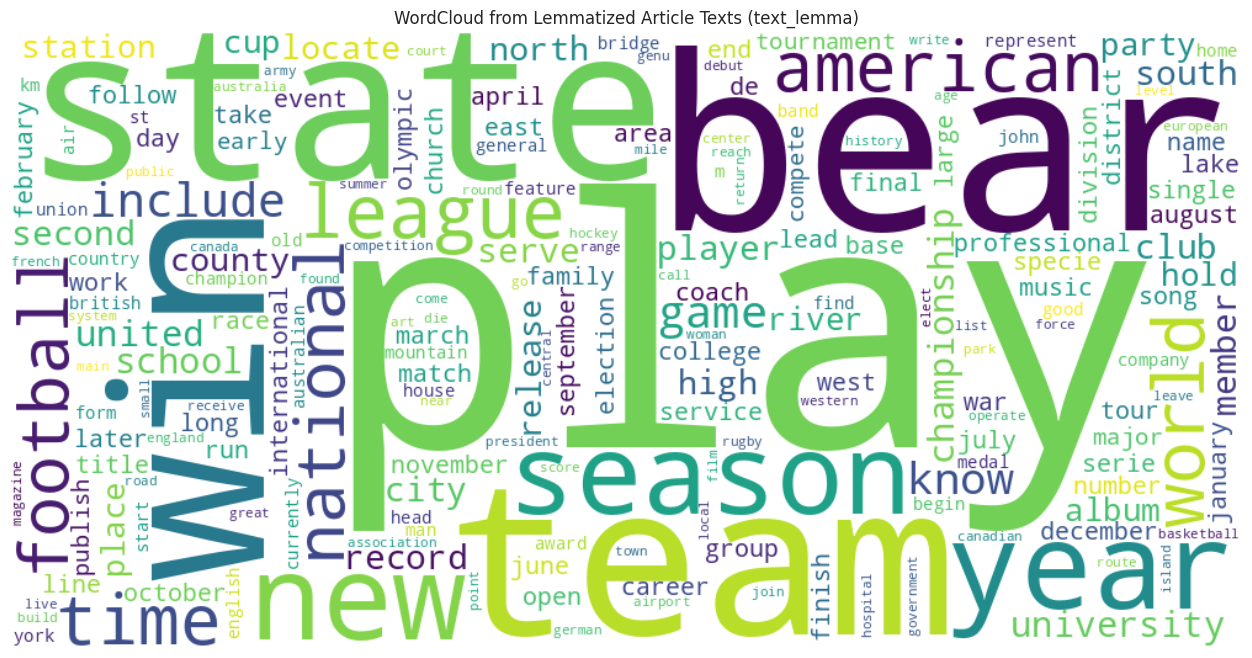


--- Analyzing Word Frequencies from 'text_lemma' column ---


/tmp/ipython-input-15-4209632013.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_most_common_lemma, palette='viridis_r') # Changed palette


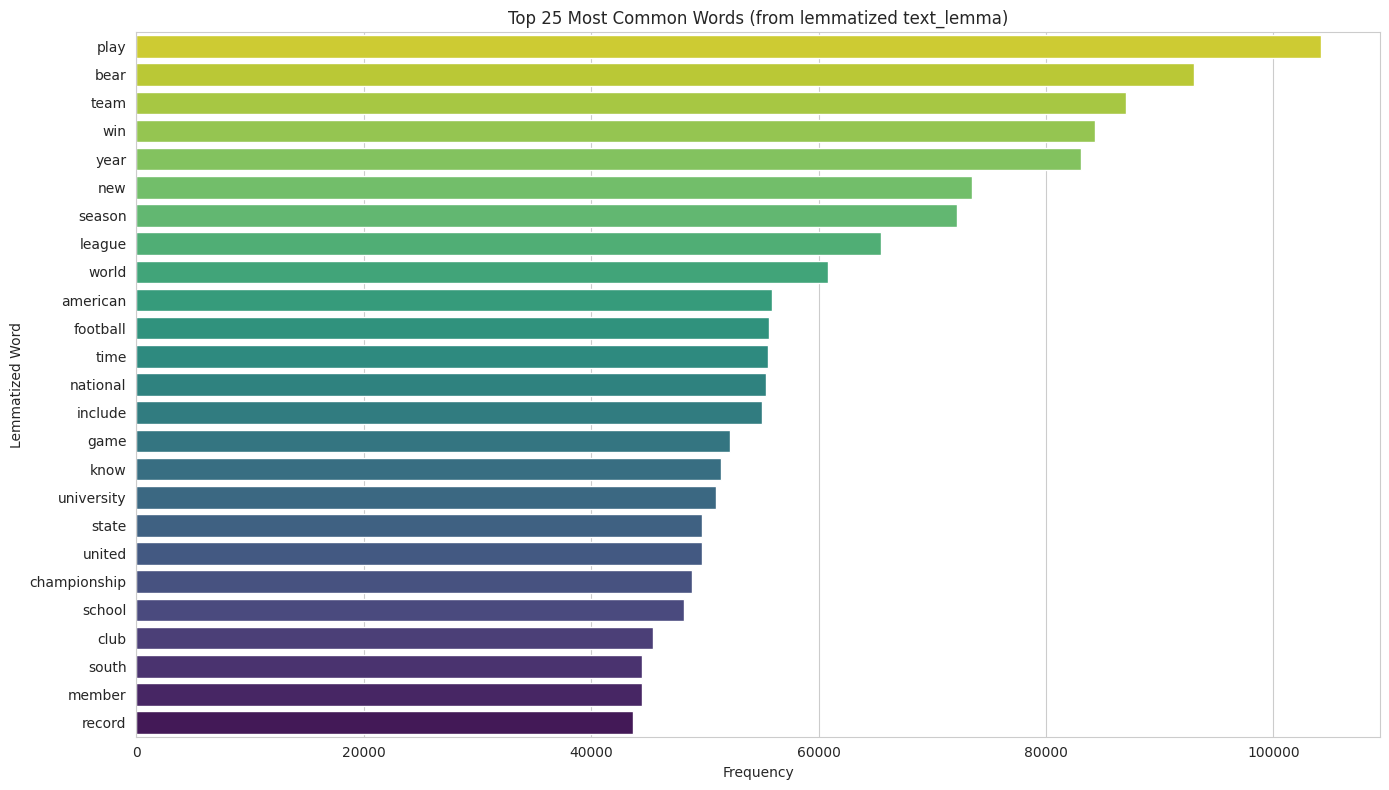

In [ ]:
# --- WordCloud from 'text_lemma' ---
print("\n--- Generating WordCloud from 'text_lemma' column ---")

# Check for NaN or non-string values in 'text_lemma' just in case
# and combine into one large string.
# spaCy's lemmatizer should produce strings, but empty strings are possible if all tokens were filtered.
# We filter out potential NaN/float values that might occur if some rows had issues during apply.
lemma_texts_for_wordcloud = df['text_lemma'].dropna().astype(str).tolist()
all_lemma_text = " ".join(lemma_texts_for_wordcloud)

if all_lemma_text.strip(): # Check if there's any text after processing
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        stopwords=None, # Stopwords should have been removed by lemmatize_for_tfidf_eda
        collocations=False # Faster and focuses on single words
    ).generate(all_lemma_text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud from Lemmatized Article Texts (text_lemma)')
    plt.show()
else:
    print("No text available in 'text_lemma' to generate WordCloud (all_lemma_text is empty or only whitespace).")
    print(f"Number of non-empty strings in text_lemma: {sum(df['text_lemma'].dropna().astype(str).str.strip().astype(bool))}")


# --- Word Frequency Analysis from 'text_lemma' ---
print("\n--- Analyzing Word Frequencies from 'text_lemma' column ---")

all_lemma_words = []
# Iterate through the 'text_lemma' column, split each entry into words, and extend the list
for text_entry in df['text_lemma'].dropna().astype(str): # Ensure we handle potential NaNs or non-strings
    all_lemma_words.extend(text_entry.split()) # .split() will handle empty strings correctly

if all_lemma_words:
    word_counts_lemma = collections.Counter(all_lemma_words)
    most_common_lemma_words = word_counts_lemma.most_common(25) # Get the 25 most common lemmatized words

    # Create a DataFrame for plotting
    df_most_common_lemma = pd.DataFrame(most_common_lemma_words, columns=['Word', 'Frequency'])

    plt.figure(figsize=(14, 8)) # Adjusted size for potentially longer words or more items
    sns.barplot(x='Frequency', y='Word', data=df_most_common_lemma, palette='viridis_r') # Changed palette
    plt.title('Top 25 Most Common Words (from lemmatized text_lemma)')
    plt.xlabel('Frequency')
    plt.ylabel('Lemmatized Word')
    plt.tight_layout()
    plt.show()
else:
    print("No words found for frequency analysis from 'text_lemma' (all_lemma_words list is empty).")
    print(f"Number of non-empty strings in text_lemma: {sum(df['text_lemma'].dropna().astype(str).str.strip().astype(bool))}")

**Dominant Themes:**

* The WordCloud prominently features words like "play", "team", "state", "bear" (likely from "born" or used in other contexts), "league", "season", "year", "new", "american", and "football".

* The bar chart of top 25 most common words confirms this, with "play" being the most frequent, followed by "bear", "team", "win", "year", and "new".

**Sports and Competition:** A significant portion of the vocabulary seems related to sports and competition (e.g., "play", "team", "league", "season", "win", "football", "championship", "game", "olympic" in WordCloud, "tournament" in WordCloud). This aligns with "SportsSeason" being an L1 category and "Athlete" being a very frequent L2 category.

**Time and Location:** Words like "year", "time", "state", "national", "world", "american", "north", "city", "country" (seen in WordCloud) suggest a focus on temporal and geographical contexts, which is common in encyclopedic articles.

**General Verbs and Concepts:** Common lemmatized verbs like "include", "serve", "find", "begin", "know" appear, as expected in descriptive texts. "Work", "record", "member", "school", "university" also point to common themes in encyclopedic content.

**Impact of Lemmatization:** The presence of "bear" as a very frequent word is interesting. It's likely the lemmatized form of "born" (e.g., "was born in...") which is extremely common in biographical articles. This highlights how lemmatization can sometimes group words that, while sharing a root, might be used in different semantic contexts in their inflected forms. It can also be the animal "bear" if there are many articles on species. Given "Species" is a major L1 category, "bear" could refer to the animal, or it could be the lemma for "bearing" or "bore" in a different context.

**Cleanliness of Data:** The fact that these common words are generally meaningful and not just remnants of noise (like "nbsp" or specific HTML artifacts) suggests our preprocessing and lemmatization steps have been effective in extracting a core vocabulary.

### Splitting

Before moving on the modeling, let's split the data.

In [6]:
# Ensure 'df' is loaded and contains the target 'l1' and feature columns
if 'df' not in globals() or df is None or 'l1' not in df.columns:
    print("DataFrame 'df' or target column 'l1' not found.")
    print("Please ensure the data loading steps were successful.")
else:
    print("--- Starting Data Splitting (70% Train, 15% Validation, 15% Test) ---")

    # Define features (X) and target (y)
    # For splitting, we can pass the whole DataFrame as X and then select columns later,
    # or select specific columns now. Let's use the whole df for X for now,
    # as the split will be based on indices.
    # The target y is 'l1'.
    X = df
    y = df['l1']

    # Set a random state for reproducibility
    RANDOM_STATE = 42

    # Step 1: Split into training (70%) and temporary (30% for validation + test)
    # df_train will contain all columns from the original df for the selected indices
    df_train, df_temp, y_train, y_temp = train_test_split(
        df, y,
        test_size=0.30,       # 30% for temp (val + test)
        random_state=RANDOM_STATE,
        stratify=y            # Stratify by the target variable 'l1'
    )

    # Step 2: Split temporary set into validation (50% of temp -> 15% of original)
    # and test (50% of temp -> 15% of original)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp, y_temp,
        test_size=0.50,       # 50% of df_temp will be test set (0.5 * 0.3 = 0.15 of original)
        random_state=RANDOM_STATE,
        stratify=y_temp       # Stratify by y_temp
    )

    print("\n--- Shapes of the Full Data Splits ---")
    print(f"Full Training set shape:   {df_train.shape}")
    print(f"Full Validation set shape: {df_val.shape}")
    print(f"Full Test set shape:       {df_test.shape}")

    print("\n--- Verifying Stratification for Full Splits (L1 category proportions) ---")
    print("\nOriginal 'l1' distribution (%):")
    print(df['l1'].value_counts(normalize=True) * 100)
    print("\nTraining set 'l1' distribution (%):")
    print(df_train['l1'].value_counts(normalize=True) * 100)
    print("\nValidation set 'l1' distribution (%):")
    print(df_val['l1'].value_counts(normalize=True) * 100)
    print("\nTest set 'l1' distribution (%):")
    print(df_test['l1'].value_counts(normalize=True) * 100)

    # --- Creating 20% Samples from each split for development ---
    print("\n--- Creating 20% Stratified Samples for Development ---")

    # Sample from df_train
    # We use train_test_split to get a stratified sample.
    # The first returned DataFrame (representing 80% here) is discarded using '_'
    _, df_train_sample = train_test_split(
        df_train,
        test_size=0.20, # We want a 20% sample
        random_state=RANDOM_STATE,
        stratify=df_train['l1']
    )

    # Sample from df_val
    _, df_val_sample = train_test_split(
        df_val,
        test_size=0.20,
        random_state=RANDOM_STATE,
        stratify=df_val['l1']
    )

    # Sample from df_test
    _, df_test_sample = train_test_split(
        df_test,
        test_size=0.20,
        random_state=RANDOM_STATE,
        stratify=df_test['l1']
    )

    print("\n--- Shapes of the Sampled Data Splits (20% of each full split) ---")
    print(f"Sample Training set shape:   {df_train_sample.shape}")
    print(f"Sample Validation set shape: {df_val_sample.shape}")
    print(f"Sample Test set shape:       {df_test_sample.shape}")

    print("\n--- Verifying Stratification for Sampled Splits (L1 category proportions) ---")
    print("\nSample Training set 'l1' distribution (%):")
    print(df_train_sample['l1'].value_counts(normalize=True) * 100)
    print("\nSample Validation set 'l1' distribution (%):")
    print(df_val_sample['l1'].value_counts(normalize=True) * 100)
    print("\nSample Test set 'l1' distribution (%):")
    print(df_test_sample['l1'].value_counts(normalize=True) * 100)

--- Starting Data Splitting (70% Train, 15% Validation, 15% Test) ---

--- Shapes of the Full Data Splits ---
Full Training set shape:   (239946, 8)
Full Validation set shape: (51417, 8)
Full Test set shape:       (51418, 8)

--- Verifying Stratification for Full Splits (L1 category proportions) ---

Original 'l1' distribution (%):
l1
Agent             51.735948
Place             18.999886
Species            9.087143
Work               8.702933
Event              7.893961
SportsSeason       2.423413
UnitOfWork         0.728453
TopicalConcept     0.325281
Device             0.102981
Name: proportion, dtype: float64

Training set 'l1' distribution (%):
l1
Agent             51.735807
Place             19.000108
Species            9.087045
Work               8.702791
Event              7.893859
SportsSeason       2.423462
UnitOfWork         0.728497
TopicalConcept     0.325490
Device             0.102940
Name: proportion, dtype: float64

Validation set 'l1' distribution (%):
l1
Agent      

In [7]:
# Ensure all relevant DataFrames are loaded
if 'df_train' in globals() and 'df_val' in globals() and 'df_test' in globals() and \
   'df_train_sample' in globals() and 'df_val_sample' in globals() and 'df_test_sample' in globals():

    print("--- Encoding Target Variable 'l1' ---")

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the encoder on the 'l1' column of the FULL training set
    # This learns the mapping from string labels to integers
    label_encoder.fit(df_train['l1'])

    # Get the mapping for reference
    print("Label mapping learned from the training set:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{class_name} -> {i}")

    # Transform 'l1' in all data splits (full and sample)
    # We will store the encoded labels in new columns, e.g., 'l1_encoded'

    # Full datasets
    df_train['l1_encoded'] = label_encoder.transform(df_train['l1'])
    df_val['l1_encoded'] = label_encoder.transform(df_val['l1'])
    df_test['l1_encoded'] = label_encoder.transform(df_test['l1'])

    # Sample datasets
    df_train_sample['l1_encoded'] = label_encoder.transform(df_train_sample['l1'])
    df_val_sample['l1_encoded'] = label_encoder.transform(df_val_sample['l1'])
    df_test_sample['l1_encoded'] = label_encoder.transform(df_test_sample['l1'])

    print("\n'l1_encoded' column created in all DataFrames.")
    print("\nExample from full training set:")
    print(df_train[['l1', 'l1_encoded']].head())

    print("\nExample from sample training set:")
    print(df_train_sample[['l1', 'l1_encoded']].head())

    # Now, when you define your y for model training, you'll use 'l1_encoded'
    # y_train_encoded = df_train['l1_encoded']
    # y_val_encoded = df_val['l1_encoded']
    # etc.

else:
    print("One or more DataFrames from the data split are missing. Skipping target encoding.")

--- Encoding Target Variable 'l1' ---
Label mapping learned from the training set:
Agent -> 0
Device -> 1
Event -> 2
Place -> 3
Species -> 4
SportsSeason -> 5
TopicalConcept -> 6
UnitOfWork -> 7
Work -> 8

'l1_encoded' column created in all DataFrames.

Example from full training set:
                  l1  l1_encoded
219993         Agent           0
241175         Agent           0
32605   SportsSeason           5
277009         Agent           0
162176         Place           3

Example from sample training set:
             l1  l1_encoded
336309    Agent           0
71277   Species           4
156211    Place           3
1934      Event           2
306727    Agent           0


Our data is now cleaned, lemmatized, split and encoded. It's time to start modeling !

# 3. Baseline Models 📉

## Mlflow setup

Let's start by configuring MLFlow and preparing the data for our first model by defining X and y.

In [9]:
# --- MLflow Configuration ---
EXPERIMENT_NAME = "DBPedia_L1_Classification_POC" # POC for Proof of Concept
mlflow.set_experiment(EXPERIMENT_NAME)
# The first time you run this, it will create the experiment.
# Subsequent runs will log to this existing experiment.
try:
    current_experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    if current_experiment is None: # If it somehow still doesn't exist (e.g., deleted from UI)
        mlflow.create_experiment(EXPERIMENT_NAME)
        current_experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    print(f"MLflow Experiment: '{current_experiment.name}' (ID: {current_experiment.experiment_id})")
except Exception as e:
    print(f"Error setting up MLflow experiment: {e}")
    print("MLflow logging might not work correctly.")


# --- Data Preparation for TF-IDF Baseline (using _sample datasets) ---
# Ensure sample DataFrames are loaded and contain 'text_lemma' and 'l1_encoded'
if 'df_train_sample' in globals() and df_train_sample is not None and \
   'df_val_sample' in globals() and df_val_sample is not None and \
   'df_test_sample' in globals() and df_test_sample is not None and \
   'text_lemma' in df_train_sample.columns and 'l1_encoded' in df_train_sample.columns:

    print("\n--- Preparing X and y for TF-IDF model from sample data ---")

    # Features: lemmatized text
    X_train_tfidf_sample = df_train_sample['text_lemma'].fillna('') # Fill NaN with empty string for TfidfVectorizer
    X_val_tfidf_sample = df_val_sample['text_lemma'].fillna('')
    X_test_tfidf_sample = df_test_sample['text_lemma'].fillna('')

    # Target: encoded labels
    y_train_encoded_sample = df_train_sample['l1_encoded']
    y_val_encoded_sample = df_val_sample['l1_encoded']
    y_test_encoded_sample = df_test_sample['l1_encoded']

    print(f"Shape of X_train_tfidf_sample: {X_train_tfidf_sample.shape}")
    print(f"Shape of y_train_encoded_sample: {y_train_encoded_sample.shape}")

    # For inverse transform of labels to names (useful for confusion matrix labels)
    # Ensure label_encoder was fitted previously
    if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
        class_names = label_encoder.classes_
        print(f"\nTarget class names for confusion matrix: {class_names}")
    else:
        # Fallback if label_encoder or its classes_ attribute is not available
        # This might happen if cells are run out of order or parts are skipped.
        # It's better to ensure label_encoder is properly initialized and fitted.
        class_names = sorted(df_train_sample['l1'].unique()) # Infer from 'l1' if 'l1_encoded' is present
        print(f"Warning: label_encoder not found or not fitted. Inferred class names: {class_names}")
        print("Confusion matrix labels might not perfectly match encoded values if this inference is incorrect.")


    # --- Define a helper function for standardized evaluation and logging ---
    def evaluate_and_log_metrics(model_name, y_true, y_pred, params=None, class_labels=None):
        """Calculates, prints, and logs standard metrics to MLflow."""
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"\nMetrics for {model_name}:")
        print(f"  Accuracy:         {accuracy:.4f}")
        print(f"  F1 (Macro):       {f1_macro:.4f}")
        print(f"  F1 (Weighted):    {f1_weighted:.4f}")
        print(f"  Precision (Macro):{precision_macro:.4f}")
        print(f"  Precision (Weighted):{precision_weighted:.4f}")
        print(f"  Recall (Macro):   {recall_macro:.4f}")
        print(f"  Recall (Weighted):{recall_weighted:.4f}")

        # MLflow logging
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_macro", f1_macro)
        mlflow.log_metric("f1_weighted", f1_weighted)
        mlflow.log_metric("precision_macro", precision_macro)
        mlflow.log_metric("precision_weighted", precision_weighted)
        mlflow.log_metric("recall_macro", recall_macro)
        mlflow.log_metric("recall_weighted", recall_weighted)

        # Log confusion matrix as an artifact
        try:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_labels if class_labels is not None else 'auto',
                        yticklabels=class_labels if class_labels is not None else 'auto')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix - {model_name}')

            # Save to a temporary file and log as artifact
            cm_path = f"confusion_matrix_{model_name.replace(' ', '_')}.png"
            plt.savefig(cm_path)
            mlflow.log_artifact(cm_path)
            plt.close() # Close the plot to avoid displaying it in the notebook here
            print(f"  Confusion matrix logged to MLflow artifacts as {cm_path}")
        except Exception as e_cm:
            print(f"  Error generating/logging confusion matrix: {e_cm}")

        return {
            "accuracy": accuracy, "f1_macro": f1_macro, "f1_weighted": f1_weighted,
            "precision_macro": precision_macro, "precision_weighted": precision_weighted,
            "recall_macro": recall_macro, "recall_weighted": recall_weighted
        }

    print("\nMLflow setup and data preparation for TF-IDF complete.")
    print("The 'evaluate_and_log_metrics' helper function is defined.")

else:
    print("Sample DataFrames ('df_train_sample', 'df_val_sample', 'df_test_sample') or required columns ('text_lemma', 'l1_encoded') not found.")
    print("Please ensure the data splitting and target encoding steps were successful.")

MLflow Experiment: 'DBPedia_L1_Classification_POC' (ID: 573081786449542606)

--- Preparing X and y for TF-IDF model from sample data ---
Shape of X_train_tfidf_sample: (47990,)
Shape of y_train_encoded_sample: (47990,)

Target class names for confusion matrix: ['Agent' 'Device' 'Event' 'Place' 'Species' 'SportsSeason'
 'TopicalConcept' 'UnitOfWork' 'Work']

MLflow setup and data preparation for TF-IDF complete.
The 'evaluate_and_log_metrics' helper function is defined.


In [10]:
# --- Accessing MLflow UI via ngrok ---

# 1. Install ngrok (run this once per session if not already installed)
#    Using pyngrok which is a Python wrapper for ngrok.
!pip install pyngrok -q

# 2. Get your ngrok authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get("NGROK_AUTH_TOKEN")

if NGROK_AUTH_TOKEN is None or NGROK_AUTH_TOKEN == "":
    print("ERROR: NGROK_AUTH_TOKEN not found or is empty in Colab secrets.")
    print("Please go to 'Secrets' (key icon on the left) and add your ngrok authtoken.")
    print("You can get it from: https://dashboard.ngrok.com/get-started/your-authtoken")
    # Stop further execution if token is missing
    raise ValueError("NGROK_AUTH_TOKEN is missing. Halting execution.")
else:
    print("NGROK_AUTH_TOKEN found in Colab secrets. Attempting to configure ngrok...")
    # Configure ngrok with the authtoken
    # This command should create/update the ngrok config file.
    !ngrok config add-authtoken {NGROK_AUTH_TOKEN}
    print("ngrok authtoken configured.")


# 3. Terminate any existing MLflow UI and ngrok processes (important for reruns)
#    This helps avoid "address already in use" errors.
!pkill -f "mlflow ui" # Kills any process with "mlflow ui" in its command
!pkill -f "ngrok"     # Kills any ngrok process

# 4. Start MLflow UI in the background
#    The 'mlruns' directory should be in your current working directory (e.g., /content/OC-NeoBERT-POC/mlruns)
#    or you can specify the backend store URI if it's elsewhere.
#    Default port is 5000.
#    We use 'nohup' to run it in the background and redirect output.
get_ipython().system_raw("nohup mlflow ui --port 5000 > mlflow_ui.log 2>&1 &")
print("Attempting to start MLflow UI in the background on port 5000...")
# Give it a few seconds to start
import time
time.sleep(5)

# 5. Start ngrok tunnel to expose port 5000
from pyngrok import ngrok

try:
    # Terminate any existing ngrok tunnels (again, for clean state)
    # ngrok.kill() # pyngrok might handle this, but pkill above is more general

    # Open a HTTP tunnel on port 5000
    # The 'public_url' variable will contain the ngrok URL
    public_url = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print(f"\nMLflow UI is hopefully running!")
    print(f"Click this link to access the MLflow UI: {public_url}")
    print("If the UI doesn't load immediately, please wait a few more seconds for MLflow and ngrok to initialize fully.")
    print("Check 'mlflow_ui.log' for any errors from MLflow UI server if it fails to start.")
    print("You can view the log with: !cat mlflow_ui.log")

except Exception as e:
    print(f"An error occurred while starting ngrok or MLflow UI: {e}")
    print("Common issues:")
    print("- Ensure your NGROK_AUTH_TOKEN is correct and ngrok is installed.")
    print("- Make sure port 5000 is not already in use by another critical process (unlikely in Colab).")
    print("- Check 'mlflow_ui.log' for MLflow server errors: !cat mlflow_ui.log")

NGROK_AUTH_TOKEN found in Colab secrets. Attempting to configure ngrok...
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok authtoken configured.
Attempting to start MLflow UI in the background on port 5000...

MLflow UI is hopefully running!
Click this link to access the MLflow UI: NgrokTunnel: "https://2b7c-34-16-189-255.ngrok-free.app" -> "http://localhost:5000"
If the UI doesn't load immediately, please wait a few more seconds for MLflow and ngrok to initialize fully.
Check 'mlflow_ui.log' for any errors from MLflow UI server if it fails to start.
You can view the log with: !cat mlflow_ui.log


In [16]:
# When you're done, you can disconnect ngrok if needed:
from pyngrok import ngrok
ngrok.disconnect(public_url) # If you stored the public_url from the tunnel object
ngrok.kill()

## TF-IDF + logistic regression

In [ ]:
# --- TF-IDF + Logistic Regression Baseline ---

# Define a run name for MLflow for better organization
tfidf_logreg_run_name = "TFIDF_LogisticRegression_Baseline_Sample"

with mlflow.start_run(run_name=tfidf_logreg_run_name) as run:
    run_id = run.info.run_id
    print(f"--- Starting MLflow Run: {tfidf_logreg_run_name} (ID: {run_id}) ---")
    mlflow.set_tag("model_type", "TF-IDF + Logistic Regression")
    mlflow.set_tag("data_scope", "Sampled (20%)")

    # --- Define Hyperparameters ---
    # We'll start with some reasonable defaults. These can be tuned later.
    tfidf_params = {
        "max_df": 0.95,       # Ignore terms that appear in more than 95% of documents
        "min_df": 5,          # Ignore terms that appear in less than 5 documents
        "max_features": 10000,# Consider top 10,000 features (words/n-grams)
        "ngram_range": (1, 1) # Consider only unigrams for simplicity first
        # "stop_words": None # Already handled in text_lemma
    }

    logreg_params = {
        "C": 1.0,                   # Inverse of regularization strength
        "solver": "saga",           # Good for larger datasets, supports L1/L2
        "penalty": "l2",            # L2 regularization is common
        "multi_class": "multinomial",# Generally better for multiclass problems
        "max_iter": 1000,            # Increased iterations for convergence
        "random_state": RANDOM_STATE # from previous cell (e.g., 42)
    }

    print(f"TF-IDF Parameters: {tfidf_params}")
    print(f"Logistic Regression Parameters: {logreg_params}")

    # Log parameters to MLflow
    # We prefix them to avoid clashes if other models have same param names
    mlflow.log_params({f"tfidf_{k}": v for k, v in tfidf_params.items()})
    mlflow.log_params({f"logreg_{k}": v for k, v in logreg_params.items()})

    # --- Create the Scikit-learn Pipeline ---
    print("\nCreating Scikit-learn pipeline...")
    tfidf_logreg_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('logreg', LogisticRegression(**logreg_params))
    ])
    print("Pipeline created.")

    # --- Train the Pipeline ---
    print("\nTraining the pipeline on the sample training data...")
    try:
        tfidf_logreg_pipeline.fit(X_train_tfidf_sample, y_train_encoded_sample)
        print("Pipeline training complete.")

        # --- Make Predictions on the Sample Validation Set ---
        print("\nMaking predictions on the sample validation set...")
        y_val_pred_sample = tfidf_logreg_pipeline.predict(X_val_tfidf_sample)
        print("Predictions complete.")

        # --- Evaluate and Log Metrics using our helper function ---
        print("\nEvaluating and logging metrics for the sample validation set...")
        # Note: 'params' argument in evaluate_and_log_metrics is for model-specific params logged at start of run
        # Here, we've already logged them.
        validation_metrics = evaluate_and_log_metrics(
            model_name=f"{tfidf_logreg_run_name} (Validation)",
            y_true=y_val_encoded_sample,
            y_pred=y_val_pred_sample,
            class_labels=class_names # Defined in the previous cell
        )

        # --- Log the trained pipeline model to MLflow ---
        print("\nLogging the trained pipeline model to MLflow...")
        mlflow.sklearn.log_model(
            sk_model=tfidf_logreg_pipeline,
            artifact_path="tfidf_logreg_model", # This will be a subfolder in the run's artifacts
            registered_model_name=None # Or provide a name to register it in MLflow Model Registry
        )
        print("Model logged to MLflow artifacts.")

    except Exception as e:
        print(f"An error occurred during training or evaluation: {e}")
        mlflow.set_tag("status", "failed")
        mlflow.log_param("error_message", str(e)) # Log the error message
        # If using newer MLflow, you might use mlflow.end_run(status="FAILED") here
        # but the `with` statement handles ending the run.
        raise # Re-raise the exception to see the full traceback

    print(f"\n--- MLflow Run (ID: {run_id}) for {tfidf_logreg_run_name} finished. ---")
    print(f"To view this run, navigate to the MLflow UI and look for experiment '{EXPERIMENT_NAME}'.")

--- Starting MLflow Run: TFIDF_LogisticRegression_Baseline_Sample (ID: 85155a6523e345489eb1983f77e14224) ---
TF-IDF Parameters: {'max_df': 0.95, 'min_df': 5, 'max_features': 10000, 'ngram_range': (1, 1)}
Logistic Regression Parameters: {'C': 1.0, 'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'max_iter': 1000, 'random_state': 42}

Creating Scikit-learn pipeline...
Pipeline created.

Training the pipeline on the sample training data...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline training complete.

Making predictions on the sample validation set...
Predictions complete.

Evaluating and logging metrics for the sample validation set...

Metrics for TFIDF_LogisticRegression_Baseline_Sample (Validation):
  Accuracy:         0.9670
  F1 (Macro):       0.9320
  F1 (Weighted):    0.9668
  Precision (Macro):0.9806
  Precision (Weighted):0.9672
  Recall (Macro):   0.8944
  Recall (Weighted):0.9670


2025/06/26 13:50:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Confusion matrix logged to MLflow artifacts as confusion_matrix_TFIDF_LogisticRegression_Baseline_Sample_(Validation).png

Logging the trained pipeline model to MLflow...


2025/06/26 13:50:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged to MLflow artifacts.

--- MLflow Run (ID: 85155a6523e345489eb1983f77e14224) for TFIDF_LogisticRegression_Baseline_Sample finished. ---
To view this run, navigate to the MLflow UI and look for experiment 'DBPedia_L1_Classification_POC'.


In [ ]:
# --- TF-IDF + Logistic Regression Baseline - TEST ---

if 'tfidf_logreg_pipeline' in globals() and \
   'X_test_tfidf_sample' in globals() and \
   'y_test_encoded_sample' in globals() and \
   'evaluate_and_log_metrics' in globals() and \
   'class_names' in globals() and \
   'tfidf_logreg_run_name' in globals() and \
   'mlflow' in globals(): # Ensure mlflow is imported

    print(f"\n--- Evaluating TF-IDF + Logistic Regression on SAMPLE TEST SET ---")
    print(f"Using the model from MLflow run: {tfidf_logreg_run_name}")

    # It's good practice to log this evaluation under the SAME MLflow run
    # if it's considered part of the same experiment iteration.
    # To do this, you would need the run_id from the previous training.
    # For simplicity here, if we are outside the original 'with mlflow.start_run()' block,
    # starting a new run or logging to an existing one requires specific handling.

    # Option A: Start a new, distinct run for test set evaluation (simpler if outside original 'with' block)
    # test_run_name = f"{tfidf_logreg_run_name}_TestSetEval"
    # with mlflow.start_run(run_name=test_run_name, experiment_id=current_experiment.experiment_id) as test_run:

    # Option B: Log to the *existing* run if you have its ID and it's still active or can be resumed.
    # This is more complex if the original 'with' block has exited.
    # For now, let's assume we want to log it as a continuation or a new run.
    # We will log it under a slightly different name to distinguish from validation metrics,
    # but ideally, these would be separate entries in the MLflow UI or tagged differently.

    # For simplicity, we'll print and if you want to log to MLflow, you'd typically
    # wrap this in a 'with mlflow.start_run()' or use an existing run_id.
    # Given the previous cell ended the run, let's start a new one for clarity for this specific evaluation.

    test_eval_run_name = f"{tfidf_logreg_run_name}_Test_Evaluation"

    with mlflow.start_run(run_name=test_eval_run_name, experiment_id=current_experiment.experiment_id) as test_eval_run:
        mlflow.set_tag("model_type", "TF-IDF + Logistic Regression")
        mlflow.set_tag("data_scope", "Sampled (20%) - Test Set")
        mlflow.set_tag("parent_run_id_for_model", run_id) # Link to the training run ID (b623...)

        # Log the parameters used for the model being tested (same as training)
        # Assuming tfidf_params and logreg_params are still in scope
        if 'tfidf_params' in globals() and 'logreg_params' in globals():
            mlflow.log_params({f"tfidf_{k}": v for k, v in tfidf_params.items()})
            mlflow.log_params({f"logreg_{k}": v for k, v in logreg_params.items()})
        else:
            mlflow.log_param("model_params_info", "Original training parameters not in current scope for logging")

        print("Making predictions on the sample test set...")
        y_test_pred_sample = tfidf_logreg_pipeline.predict(X_test_tfidf_sample)
        print("Predictions complete.")

        print("\nEvaluating and logging metrics for the sample test set...")
        test_metrics = evaluate_and_log_metrics(
            model_name=f"{test_eval_run_name}", # Use the new run name for clarity in output
            y_true=y_test_encoded_sample,
            y_pred=y_test_pred_sample,
            class_labels=class_names
        )
        print(f"\n--- MLflow Run (ID: {test_eval_run.info.run_id}) for {test_eval_run_name} finished. ---")

else:
    print("One or more necessary variables (pipeline, test data, helper functions) are not defined.")
    print("Please ensure the previous training and data preparation cells were executed successfully.")


--- Evaluating TF-IDF + Logistic Regression on SAMPLE TEST SET ---
Using the model from MLflow run: TFIDF_LogisticRegression_Baseline_Sample
Making predictions on the sample test set...
Predictions complete.

Evaluating and logging metrics for the sample test set...

Metrics for TFIDF_LogisticRegression_Baseline_Sample_Test_Evaluation:
  Accuracy:         0.9662
  F1 (Macro):       0.9287
  F1 (Weighted):    0.9658
  Precision (Macro):0.9782
  Precision (Weighted):0.9663
  Recall (Macro):   0.8998
  Recall (Weighted):0.9662
  Confusion matrix logged to MLflow artifacts as confusion_matrix_TFIDF_LogisticRegression_Baseline_Sample_Test_Evaluation.png

--- MLflow Run (ID: dda70ad451554ac791bc84a3708632e6) for TFIDF_LogisticRegression_Baseline_Sample_Test_Evaluation finished. ---


## DistilBERT

In [ ]:
# --- Configuration for DistilBERT ---
MODEL_NAME = "distilbert-base-cased"
MAX_LENGTH = 256 # Max sequence length for tokenizer (can be tuned: 128, 256, 512)
BATCH_SIZE = 16    # Batch size for training and validation (can be tuned)

# --- Ensure sample DataFrames and helper functions are available ---
if 'df_train_sample' not in globals() or \
   'evaluate_and_log_metrics' not in globals() or \
   'current_experiment' not in globals() or \
   'class_names' not in globals():
    print("One or more required variables/functions are missing (df_train_sample, evaluate_and_log_metrics, etc.).")
    print("Please ensure previous cells have been executed successfully.")
    # You might want to stop execution here or handle this more gracefully
    # For now, we'll assume they exist for the rest of the script.
    # raise NameError("Prerequisite variables not defined.")

# --- 1. Prepare X and y for DistilBERT (using _sample datasets) ---
print("\n--- Preparing X and y for DistilBERT model from sample data ---")
# Using 'text_transformer' which preserves case, suitable for 'distilbert-base-cased'
X_train_distil_sample = df_train_sample['text_transformer'].fillna('').astype(str).tolist()
X_val_distil_sample = df_val_sample['text_transformer'].fillna('').astype(str).tolist()
X_test_distil_sample = df_test_sample['text_transformer'].fillna('').astype(str).tolist()

y_train_distil_sample_encoded = df_train_sample['l1_encoded'].tolist()
y_val_distil_sample_encoded = df_val_sample['l1_encoded'].tolist()
y_test_distil_sample_encoded = df_test_sample['l1_encoded'].tolist()

print(f"Number of training examples: {len(X_train_distil_sample)}")
print(f"Number of validation examples: {len(X_val_distil_sample)}")
print(f"Number of test examples: {len(X_test_distil_sample)}")

# --- 2. Load Tokenizer ---
print(f"\n--- Loading Tokenizer: {MODEL_NAME} ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

# --- 3. Tokenize Data ---
print("\n--- Tokenizing data ---")
# We'll tokenize each set separately
train_encodings = tokenizer(X_train_distil_sample, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
val_encodings = tokenizer(X_val_distil_sample, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(X_test_distil_sample, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
print("Data tokenized.")
print(f"Shape of train_encodings['input_ids']: {train_encodings['input_ids'].shape}")

# --- 4. Create PyTorch Datasets ---
print("\n--- Creating PyTorch Datasets ---")
class DBPediaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # For item, we need all keys from the tokenizer output (input_ids, attention_mask, etc.)
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DBPediaDataset(train_encodings, y_train_distil_sample_encoded)
val_dataset = DBPediaDataset(val_encodings, y_val_distil_sample_encoded)
test_dataset = DBPediaDataset(test_encodings, y_test_distil_sample_encoded)
print("PyTorch Datasets created.")

# --- 5. Create PyTorch DataLoaders ---
print("\n--- Creating PyTorch DataLoaders ---")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers > 0 can speed up data loading
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"DataLoaders created with batch size: {BATCH_SIZE}")

# --- 6. Define Device (GPU or CPU) ---
print("\n--- Defining device ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 7. Load Pre-trained Model --- (EXISTING CODE)
print(f"\n--- Loading Pre-trained Model: {MODEL_NAME} ---")
num_labels = len(class_names)
distil_model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
# distil_model.to(device) # We'll move to device after modifying parameters

# --- Layer Freezing Strategy ---
print("\n--- Applying Layer Freezing Strategy ---")
# Freeze all parameters initially
for param in distil_model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head and the pre_classifier layer
if hasattr(distil_model, 'classifier'):
    for param in distil_model.classifier.parameters():
        param.requires_grad = True
    print("Unfroze classifier layer.")

if hasattr(distil_model, 'pre_classifier'): # DistilBERT has this
    for param in distil_model.pre_classifier.parameters():
        param.requires_grad = True
    print("Unfroze pre_classifier layer.")

# Unfreeze the last N transformer layers
# DistilBERT has 6 layers (0 to 5 in distilbert.transformer.layer)
num_transformer_layers_to_unfreeze = 2 # Example: unfreeze last 2 layers

if hasattr(distil_model, 'distilbert') and hasattr(distil_model.distilbert, 'transformer') and hasattr(distil_model.distilbert.transformer, 'layer'):
    total_layers = len(distil_model.distilbert.transformer.layer)
    for i in range(total_layers - num_transformer_layers_to_unfreeze, total_layers):
        if i >= 0: # Ensure index is not negative
            print(f"Unfreezing Transformer layer {i}...")
            for param in distil_model.distilbert.transformer.layer[i].parameters():
                param.requires_grad = True
else:
    print("Could not find transformer layers to unfreeze with the expected structure.")


# Move model to device AFTER modifying requires_grad
distil_model.to(device)
print(f"Model '{MODEL_NAME}' loaded, layers partially unfrozen, and moved to {device}.")

# Verify which parameters are trainable
print("\nTrainable parameters:")
for name, param in distil_model.named_parameters():
    if param.requires_grad:
        print(name)


--- Creating PyTorch Datasets ---


In [ ]:
# --- Training Configuration for DistilBERT ---

# Hyperparameters for training
LEARNING_RATE = 5e-5 # Common starting point for fine-tuning BERT-like models
EPOCHS = 4           # Number of training epochs (3-5 is often good for fine-tuning)
# ADAM_EPSILON = 1e-8  # Default for AdamW in Hugging Face
WARMUP_STEPS_RATIO = 0.1 # Percentage of total training steps for warmup

# For Early Stopping and Best Model Saving
PATIENCE_EARLY_STOPPING = 2 # Number of epochs to wait for improvement before stopping
BEST_MODEL_SAVE_PATH = "best_distilbert_model_sample.pth" # Path to save the best model

# --- Start MLflow Run for DistilBERT Training ---
distilbert_run_name = f"{MODEL_NAME}_Baseline_Sample_LR{LEARNING_RATE}_E{EPOCHS}"

with mlflow.start_run(run_name=distilbert_run_name, experiment_id=current_experiment.experiment_id) as run:
    distil_run_id = run.info.run_id
    print(f"--- Starting MLflow Run: {distilbert_run_name} (ID: {distil_run_id}) ---")
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("data_scope", "Sampled (20%)")
    mlflow.log_param("model_name_hf", MODEL_NAME)
    mlflow.log_param("max_sequence_length", MAX_LENGTH)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("warmup_steps_ratio", WARMUP_STEPS_RATIO)
    # mlflow.log_param("adam_epsilon", ADAM_EPSILON) # If you decide to make it configurable

    # --- Optimizer and Scheduler ---
    # IMPORTANT: Pass only trainable parameters to the optimizer
    trainable_params = [p for p in distil_model.parameters() if p.requires_grad]
    print(f"\nNumber of trainable parameters: {sum(p.numel() for p in trainable_params)}")

    optimizer = optim.AdamW(trainable_params, lr=LEARNING_RATE) # Pass only trainable_params

    total_training_steps = len(train_loader) * EPOCHS
    num_warmup_steps = int(total_training_steps * WARMUP_STEPS_RATIO)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_training_steps
    )
    print(f"Optimizer: AdamW (on TRAINABLE parameters only), Scheduler: Linear warmup ({num_warmup_steps} steps) then decay.")
    print(f"Total training steps: {total_training_steps}")

    # --- Training Loop ---
    best_val_f1_weighted = -1.0 # Initialize best validation F1 score
    epochs_no_improve = 0       # Counter for early stopping

    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")

        # --- Training Phase ---
        distil_model.train() # Set model to training mode
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False)

        for batch_num, batch in enumerate(train_progress_bar):
            optimizer.zero_grad() # Clear previous gradients

            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = distil_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()       # Backpropagate the loss
            torch.nn.utils.clip_grad_norm_(distil_model.parameters(), 1.0) # Gradient clipping
            optimizer.step()      # Update weights
            scheduler.step()      # Update learning rate

            train_progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"  Average Training Loss: {avg_train_loss:.4f}")
        mlflow.log_metric("train_loss_epoch", avg_train_loss, step=epoch)

        # --- Validation Phase ---
        distil_model.eval() # Set model to evaluation mode
        total_val_loss = 0
        all_val_preds = []
        all_val_labels = []

        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False)
        with torch.no_grad(): # Disable gradient calculations for validation
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = distil_model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                val_progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"  Average Validation Loss: {avg_val_loss:.4f}")
        mlflow.log_metric("val_loss_epoch", avg_val_loss, step=epoch)

        print(f"  Evaluating validation metrics for Epoch {epoch+1}...")
        # Use a temporary name for these epoch-specific metrics in MLflow if desired
        # or log them with the 'step' parameter.
        # Our `evaluate_and_log_metrics` function logs to the current active run.
        # We need to make sure MLflow knows these are per-epoch metrics.
        # For now, let's log them directly with `step=epoch` for key metrics.

        val_metrics = evaluate_and_log_metrics(
            model_name=f"{distilbert_run_name} (Val Epoch {epoch+1})", # This name is for console output
            y_true=np.array(all_val_labels),
            y_pred=np.array(all_val_preds),
            class_labels=class_names
        )
        # Log key validation metrics with step for MLflow UI plotting per epoch
        mlflow.log_metric("val_accuracy_epoch", val_metrics["accuracy"], step=epoch)
        mlflow.log_metric("val_f1_weighted_epoch", val_metrics["f1_weighted"], step=epoch)
        mlflow.log_metric("val_f1_macro_epoch", val_metrics["f1_macro"], step=epoch)


        # --- Best Model Saving & Early Stopping Logic ---
        current_val_f1_weighted = val_metrics["f1_weighted"]
        if current_val_f1_weighted > best_val_f1_weighted:
            print(f"  Validation F1-Weighted improved from {best_val_f1_weighted:.4f} to {current_val_f1_weighted:.4f}.")
            best_val_f1_weighted = current_val_f1_weighted
            torch.save(distil_model.state_dict(), BEST_MODEL_SAVE_PATH)
            print(f"  Best model saved to {BEST_MODEL_SAVE_PATH}")
            epochs_no_improve = 0
            mlflow.set_tag("best_epoch", epoch + 1) # Tag the best epoch
            mlflow.log_metric("best_val_f1_weighted", best_val_f1_weighted) # Log the best score so far
        else:
            epochs_no_improve += 1
            print(f"  Validation F1-Weighted did not improve for {epochs_no_improve} epoch(s). Best was {best_val_f1_weighted:.4f}.")

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"\nEarly stopping triggered after {PATIENCE_EARLY_STOPPING} epochs with no improvement.")
            break # Exit training loop

    # --- End of Training Loop ---

    # --- Load Best Model and Evaluate on Test Set (Sample) ---
    if os.path.exists(BEST_MODEL_SAVE_PATH):
        print(f"\n--- Loading best model from {BEST_MODEL_SAVE_PATH} for test set evaluation ---")
        distil_model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH))
        distil_model.to(device) # Ensure model is on the correct device
        distil_model.eval()   # Set to evaluation mode

        all_test_preds = []
        all_test_labels = []
        test_progress_bar = tqdm(test_loader, desc="Final Test Set Evaluation", leave=False)
        with torch.no_grad():
            for batch in test_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = distil_model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        print("\nEvaluating and logging metrics for the SAMPLE TEST set (using best epoch model)...")
        # Log these as final test metrics in MLflow
        # Our `evaluate_and_log_metrics` will log them with the current run.
        # We can prefix metric names in MLflow if needed, or rely on distinct logging within the function.
        # For simplicity, we'll let `evaluate_and_log_metrics` log them directly,
        # but you might want to adjust its internal logging or call mlflow.log_metric with prefixes like "test_accuracy".
        # Let's adjust the model_name for console output for clarity
        test_set_metrics = evaluate_and_log_metrics(
            model_name=f"{distilbert_run_name} (Test Set)", # For console output
            y_true=np.array(all_test_labels),
            y_pred=np.array(all_test_preds),
            class_labels=class_names
        )
        # Explicitly log test metrics with a "test_" prefix for clarity in MLflow UI
        for metric_name, metric_value in test_set_metrics.items():
            mlflow.log_metric(f"test_{metric_name}", metric_value)

        # --- Log the best model to MLflow Artifacts ---
        print("\nLogging the best fine-tuned DistilBERT model to MLflow...")
        mlflow.pytorch.log_model(
            pytorch_model=distil_model, # The model with best weights loaded
            artifact_path="distilbert_best_model_sample",
            # signature=... # Optional: define model signature
            # input_example=... # Optional: provide an input example
            # registered_model_name=f"{MODEL_NAME}-DBPedia-L1-Sample" # Optional
        )
        print("Best DistilBERT model logged to MLflow artifacts.")
    else:
        print(f"No best model found at {BEST_MODEL_SAVE_PATH}. Skipping test set evaluation and model logging.")

    print(f"\n--- MLflow Run (ID: {distil_run_id}) for {distilbert_run_name} finished. ---")

--- Starting MLflow Run: distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (ID: d20dd7ec16c84871b33888e7c5b9eb8c) ---

Number of trainable parameters: 14773257
Optimizer: AdamW (on TRAINABLE parameters only), Scheduler: Linear warmup (1200 steps) then decay.
Total training steps: 12000

--- Epoch 1/4 ---


Epoch 1 Training:   0%|          | 0/3000 [00:00<?, ?it/s]

  Average Training Loss: 0.1924


Epoch 1 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Average Validation Loss: 0.0359
  Evaluating validation metrics for Epoch 1...

Metrics for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (Val Epoch 1):
  Accuracy:         0.9932
  F1 (Macro):       0.9926
  F1 (Weighted):    0.9932
  Precision (Macro):0.9944
  Precision (Weighted):0.9932
  Recall (Macro):   0.9909
  Recall (Weighted):0.9932
  Confusion matrix logged to MLflow artifacts as confusion_matrix_distilbert-base-cased_Baseline_Sample_LR5e-05_E4_(Val_Epoch_1).png
  Validation F1-Weighted improved from -1.0000 to 0.9932.
  Best model saved to best_distilbert_model_sample.pth

--- Epoch 2/4 ---


Epoch 2 Training:   0%|          | 0/3000 [00:00<?, ?it/s]

  Average Training Loss: 0.0253


Epoch 2 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Average Validation Loss: 0.0284
  Evaluating validation metrics for Epoch 2...

Metrics for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (Val Epoch 2):
  Accuracy:         0.9938
  F1 (Macro):       0.9929
  F1 (Weighted):    0.9938
  Precision (Macro):0.9933
  Precision (Weighted):0.9938
  Recall (Macro):   0.9926
  Recall (Weighted):0.9938
  Confusion matrix logged to MLflow artifacts as confusion_matrix_distilbert-base-cased_Baseline_Sample_LR5e-05_E4_(Val_Epoch_2).png
  Validation F1-Weighted improved from 0.9932 to 0.9938.
  Best model saved to best_distilbert_model_sample.pth

--- Epoch 3/4 ---


Epoch 3 Training:   0%|          | 0/3000 [00:00<?, ?it/s]

  Average Training Loss: 0.0131


Epoch 3 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Average Validation Loss: 0.0299
  Evaluating validation metrics for Epoch 3...

Metrics for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (Val Epoch 3):
  Accuracy:         0.9945
  F1 (Macro):       0.9919
  F1 (Weighted):    0.9945
  Precision (Macro):0.9953
  Precision (Weighted):0.9945
  Recall (Macro):   0.9887
  Recall (Weighted):0.9945
  Confusion matrix logged to MLflow artifacts as confusion_matrix_distilbert-base-cased_Baseline_Sample_LR5e-05_E4_(Val_Epoch_3).png
  Validation F1-Weighted improved from 0.9938 to 0.9945.
  Best model saved to best_distilbert_model_sample.pth

--- Epoch 4/4 ---


Epoch 4 Training:   0%|          | 0/3000 [00:00<?, ?it/s]

  Average Training Loss: 0.0070


Epoch 4 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Average Validation Loss: 0.0272
  Evaluating validation metrics for Epoch 4...

Metrics for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (Val Epoch 4):
  Accuracy:         0.9948
  F1 (Macro):       0.9956
  F1 (Weighted):    0.9948
  Precision (Macro):0.9949
  Precision (Weighted):0.9949
  Recall (Macro):   0.9962
  Recall (Weighted):0.9948
  Confusion matrix logged to MLflow artifacts as confusion_matrix_distilbert-base-cased_Baseline_Sample_LR5e-05_E4_(Val_Epoch_4).png
  Validation F1-Weighted improved from 0.9945 to 0.9948.
  Best model saved to best_distilbert_model_sample.pth

--- Loading best model from best_distilbert_model_sample.pth for test set evaluation ---


Final Test Set Evaluation:   0%|          | 0/643 [00:00<?, ?it/s]


Evaluating and logging metrics for the SAMPLE TEST set (using best epoch model)...

Metrics for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 (Test Set):
  Accuracy:         0.9934
  F1 (Macro):       0.9896
  F1 (Weighted):    0.9934
  Precision (Macro):0.9904
  Precision (Weighted):0.9934
  Recall (Macro):   0.9888
  Recall (Weighted):0.9934


2025/06/26 15:22:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Confusion matrix logged to MLflow artifacts as confusion_matrix_distilbert-base-cased_Baseline_Sample_LR5e-05_E4_(Test_Set).png

Logging the best fine-tuned DistilBERT model to MLflow...


2025/06/26 15:22:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/26 15:22:30 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/26 15:22:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best DistilBERT model logged to MLflow artifacts.

--- MLflow Run (ID: d20dd7ec16c84871b33888e7c5b9eb8c) for distilbert-base-cased_Baseline_Sample_LR5e-05_E4 finished. ---


# 4. ModernBERT Implementation (New Model) ✨

In [ ]:
# ==============================================================================
# CONFIGURATION CELL FOR ModernBERT
# ==============================================================================

# --- Part 1: Configuration & Sanity Checks ---
print("--- Part 1: CONFIGURATION ---")
MODEL_NAME_MODERNBERT = "answerdotai/ModernBERT-base"
MAX_LENGTH_MODERNBERT = 512 # Good starting point
BATCH_SIZE_MODERNBERT = 16  # We can try a larger batch size than NeoBERT as it's smaller (149M vs 250M)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Part 2: Data Preparation ---
print("\n--- Part 2: DATA PREPARATION ---")
X_train_modernbert_sample = df_train_sample['text_transformer'].fillna('').astype(str).tolist()
X_val_modernbert_sample = df_val_sample['text_transformer'].fillna('').astype(str).tolist()
X_test_modernbert_sample = df_test_sample['text_transformer'].fillna('').astype(str).tolist()
y_train_modernbert_sample_encoded = df_train_sample['l1_encoded'].tolist()
y_val_modernbert_sample_encoded = df_val_sample['l1_encoded'].tolist()
y_test_modernbert_sample_encoded = df_test_sample['l1_encoded'].tolist()

print(f"Loading Tokenizer: {MODEL_NAME_MODERNBERT}...")
modernbert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_MODERNBERT)

print("Tokenizing data...")
train_encodings_modernbert = modernbert_tokenizer(X_train_modernbert_sample, truncation=True, padding=True, max_length=MAX_LENGTH_MODERNBERT, return_tensors="pt")
val_encodings_modernbert = modernbert_tokenizer(X_val_modernbert_sample, truncation=True, padding=True, max_length=MAX_LENGTH_MODERNBERT, return_tensors="pt")
test_encodings_modernbert = modernbert_tokenizer(X_test_modernbert_sample, truncation=True, padding=True, max_length=MAX_LENGTH_MODERNBERT, return_tensors="pt")

# Re-defining Dataset class for self-containment
class DBPediaDataset(Dataset):
    def __init__(self, encodings, labels): self.encodings, self.labels = encodings, labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]); return item
    def __len__(self): return len(self.labels)

train_dataset_modernbert = DBPediaDataset(train_encodings_modernbert, y_train_modernbert_sample_encoded)
val_dataset_modernbert = DBPediaDataset(val_encodings_modernbert, y_val_modernbert_sample_encoded)
test_dataset_modernbert = DBPediaDataset(test_encodings_modernbert, y_test_modernbert_sample_encoded)

train_loader_modernbert = DataLoader(train_dataset_modernbert, batch_size=BATCH_SIZE_MODERNBERT, shuffle=True, num_workers=2)
val_loader_modernbert = DataLoader(val_dataset_modernbert, batch_size=BATCH_SIZE_MODERNBERT, shuffle=False, num_workers=2)
test_loader_modernbert = DataLoader(test_dataset_modernbert, batch_size=BATCH_SIZE_MODERNBERT, shuffle=False, num_workers=2)
print(f"DataLoaders for ModernBERT created with batch size: {BATCH_SIZE_MODERNBERT}")

# ==============================================================================
# Part 3: MODEL LOADING & CONFIGURATION (CORRECTED)
# ==============================================================================
print("\n--- Part 3: MODEL LOADING & CONFIGURATION ---")
try:
    print(f"\nLoading model from Hugging Face Hub: '{MODEL_NAME_MODERNBERT}'...")
    num_labels = len(class_names)
    modernbert_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME_MODERNBERT,
        num_labels=num_labels
    )
    print("✅ ModernBERT model for sequence classification loaded successfully.")

    print("\nApplying Layer Freezing Strategy...")
    # Freeze all parameters first
    for param in modernbert_model.parameters(): param.requires_grad = False

    # Unfreeze the final classifier layer
    for param in modernbert_model.classifier.parameters(): param.requires_grad = True
    print("- Unfroze 'classifier' layer.")

    # Unfreeze the last N transformer layers using the CORRECT path
    num_layers_to_unfreeze = 2
    try:
        # Path identified from the print(model) output: model -> model -> layers
        all_layers = modernbert_model.model.layers
        total_layers = len(all_layers)
        print(f"ModernBERT base model has {total_layers} transformer layers.") # Should be 22

        for i in range(total_layers - num_layers_to_unfreeze, total_layers):
            if i >= 0:
                print(f"- Unfreezing ModernBERT Transformer layer {i}...")
                for param in all_layers[i].parameters():
                    param.requires_grad = True
    except AttributeError:
        print("❌ ERROR: Path `modernbert_model.model.layers` not found. This should not happen now.")

    modernbert_model.to(device)
    print(f"Model configured and moved to {device}.")

    # Verify the number of trainable parameters
    trainable_params_count = sum(p.numel() for p in modernbert_model.parameters() if p.requires_grad)
    print(f"\nNumber of trainable parameters: {trainable_params_count:,}")

    print("\n--- Setup for ModernBERT complete. Ready for training loop. ---")

except Exception as e:
    print(f"❌ An error occurred during the model loading and configuration: {e}")

--- Part 1: CONFIGURATION ---
Using device: cuda

--- Part 2: DATA PREPARATION ---
Loading Tokenizer: answerdotai/ModernBERT-base...
Tokenizing data...
DataLoaders for ModernBERT created with batch size: 16

--- Part 3: MODEL LOADING & CONFIGURATION ---

Loading model from Hugging Face Hub: 'answerdotai/ModernBERT-base'...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ModernBERT model for sequence classification loaded successfully.

Applying Layer Freezing Strategy...
- Unfroze 'classifier' layer.
ModernBERT base model has 22 transformer layers.
- Unfreezing ModernBERT Transformer layer 20...
- Unfreezing ModernBERT Transformer layer 21...
Model configured and moved to cuda.

Number of trainable parameters: 10,037,001

--- Setup for ModernBERT complete. Ready for training loop. ---


In [ ]:
# ==============================================================================
# TRAINING AND EVALUATION CELL FOR MODERNBERT
# ==============================================================================

# --- Training Configuration ---
LEARNING_RATE_MODERNBERT = 2e-5 # Common learning rate for fine-tuning
EPOCHS_MODERNBERT = 4           # Number of epochs
PATIENCE_EARLY_STOPPING_MODERNBERT = 2 # Patience for early stopping
BEST_MODEL_SAVE_PATH_MODERNBERT = "best_modernbert_model_sample.pth"
WARMUP_STEPS_RATIO_MODERNBERT = 0.1

# --- Start MLflow Run ---
modernbert_run_name = f"ModernBERT_FineTuning_Sample_LR{LEARNING_RATE_MODERNBERT}_E{EPOCHS_MODERNBERT}"

with mlflow.start_run(run_name=modernbert_run_name, experiment_id=current_experiment.experiment_id) as run:
    modernbert_run_id = run.info.run_id
    print(f"--- Starting MLflow Run: {modernbert_run_name} (ID: {modernbert_run_id}) ---")
    mlflow.set_tag("model_type", "ModernBERT")
    mlflow.set_tag("data_scope", "Sampled (20%)")
    mlflow.log_param("model_name_hf", MODEL_NAME_MODERNBERT)
    mlflow.log_param("max_sequence_length", MAX_LENGTH_MODERNBERT)
    mlflow.log_param("batch_size", BATCH_SIZE_MODERNBERT)
    mlflow.log_param("learning_rate", LEARNING_RATE_MODERNBERT)
    mlflow.log_param("epochs", EPOCHS_MODERNBERT)
    mlflow.log_param("warmup_steps_ratio", WARMUP_STEPS_RATIO_MODERNBERT)

    # --- Optimizer and Scheduler ---
    trainable_params_modernbert = [p for p in modernbert_model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params_modernbert, lr=LEARNING_RATE_MODERNBERT)

    total_training_steps = len(train_loader_modernbert) * EPOCHS_MODERNBERT
    num_warmup_steps = int(total_training_steps * WARMUP_STEPS_RATIO_MODERNBERT)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_training_steps)
    print(f"Optimizer and Scheduler configured for {sum(p.numel() for p in trainable_params_modernbert):,} trainable parameters.")

    # --- Training Loop ---
    history = {'train_loss': [], 'val_loss': []}
    best_val_f1_weighted = -1.0
    epochs_no_improve = 0

    for epoch in range(EPOCHS_MODERNBERT):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS_MODERNBERT} ---")

        modernbert_model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader_modernbert, desc=f"Epoch {epoch+1} Training", leave=False)
        for batch in train_progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = modernbert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params_modernbert, 1.0)
            optimizer.step()
            scheduler.step()
            train_progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader_modernbert)
        history['train_loss'].append(avg_train_loss)
        print(f"  Average Training Loss: {avg_train_loss:.4f}")
        mlflow.log_metric("train_loss_epoch", avg_train_loss, step=epoch)

        modernbert_model.eval()
        total_val_loss = 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader_modernbert, desc=f"Epoch {epoch+1} Validation", leave=False):
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = modernbert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss, logits = outputs.loss, outputs.logits
                total_val_loss += loss.item()
                all_val_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader_modernbert)
        history['val_loss'].append(avg_val_loss)
        print(f"  Average Validation Loss: {avg_val_loss:.4f}")
        mlflow.log_metric("val_loss_epoch", avg_val_loss, step=epoch)

        val_metrics = evaluate_and_log_metrics(f"{modernbert_run_name} (Val Epoch {epoch+1})", np.array(all_val_labels), np.array(all_val_preds), class_labels=class_names)
        mlflow.log_metric("val_accuracy_epoch", val_metrics["accuracy"], step=epoch)
        mlflow.log_metric("val_f1_weighted_epoch", val_metrics["f1_weighted"], step=epoch)

        current_val_f1 = val_metrics["f1_weighted"]
        if current_val_f1 > best_val_f1_weighted:
            print(f"  Validation F1-Weighted improved from {best_val_f1_weighted:.4f} to {current_val_f1:.4f}. Saving model.")
            best_val_f1_weighted = current_val_f1
            torch.save(modernbert_model.state_dict(), BEST_MODEL_SAVE_PATH_MODERNBERT)
            epochs_no_improve = 0
            mlflow.set_tag("best_epoch", epoch + 1)
            mlflow.log_metric("best_val_f1_weighted", best_val_f1_weighted)
        else:
            epochs_no_improve += 1
            print(f"  Validation F1-Weighted did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING_MODERNBERT:
            print(f"\nEarly stopping triggered.")
            break

    # --- End of Training Loop ---

    print("\n--- Plotting and Logging Learning Curves ---")
    plt.figure(figsize=(10, 6)); plt.plot(history['train_loss'], label='Training Loss'); plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves - {modernbert_run_name}'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.xticks(range(len(history['train_loss']))); plt.legend(); plt.grid(True)
    learning_curves_path = "learning_curves_modernbert.png"; plt.savefig(learning_curves_path); mlflow.log_artifact(learning_curves_path); plt.close()
    print("Learning curves plot logged to MLflow artifacts.")

    if os.path.exists(BEST_MODEL_SAVE_PATH_MODERNBERT):
        print(f"\n--- Loading best model for test set evaluation ---")
        modernbert_model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH_MODERNBERT))
        modernbert_model.eval()
        all_test_preds, all_test_labels = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader_modernbert, desc="Evaluating on Test Set", leave=False):
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = modernbert_model(input_ids=input_ids, attention_mask=attention_mask)
                all_test_preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        print("\nEvaluating and logging metrics for the SAMPLE TEST set...")
        test_metrics = evaluate_and_log_metrics(f"{modernbert_run_name} (Test Set)", np.array(all_test_labels), np.array(all_test_preds), class_labels=class_names)
        for name, value in test_metrics.items(): mlflow.log_metric(f"test_{name}", value)

        print("\nLogging the best ModernBERT model to MLflow...")
        mlflow.pytorch.log_model(pytorch_model=modernbert_model, artifact_path="modernbert_best_model_sample")
        print("Best model logged to MLflow artifacts.")
    else:
        print(f"\nBest model was not saved at '{BEST_MODEL_SAVE_PATH_MODERNBERT}'. Skipping test set evaluation.")

    print(f"\n--- MLflow Run (ID: {modernbert_run_id}) for {modernbert_run_name} finished. ---")

--- Démarrage du Run MLflow : ModernBERT_FineTuning_Sample_LR2e-05_E4 (ID: 47d76b8277234abbaf6fc2f681d7423a) ---
Optimiseur et Scheduler configurés pour 14 paramètres entraînables.

--- Époque 1/4 ---


Époque 1 Entraînement:   0%|          | 0/3000 [00:00<?, ?it/s]

  Perte moyenne d'entraînement : 0.3921


Époque 1 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

W0628 13:15:12.708000 15882 torch/_inductor/utils.py:1137] [1/3] Not enough SMs to use max_autotune_gemm mode


  Perte moyenne de validation : 0.0476

Metrics for ModernBERT_FineTuning_Sample_LR2e-05_E4 (Val Époque 1):
  Accuracy:         0.9859
  F1 (Macro):       0.9806
  F1 (Weighted):    0.9859
  Precision (Macro):0.9813
  Precision (Weighted):0.9859
  Recall (Macro):   0.9799
  Recall (Weighted):0.9859
  Confusion matrix logged to MLflow artifacts as confusion_matrix_ModernBERT_FineTuning_Sample_LR2e-05_E4_(Val_Époque_1).png
  Amélioration du F1 pondéré de validation : -1.0000 -> 0.9859. Sauvegarde du modèle.

--- Époque 2/4 ---


Époque 2 Entraînement:   0%|          | 0/3000 [00:00<?, ?it/s]

  Perte moyenne d'entraînement : 0.0368


Époque 2 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Perte moyenne de validation : 0.0398

Metrics for ModernBERT_FineTuning_Sample_LR2e-05_E4 (Val Époque 2):
  Accuracy:         0.9890
  F1 (Macro):       0.9869
  F1 (Weighted):    0.9890
  Precision (Macro):0.9861
  Precision (Weighted):0.9891
  Recall (Macro):   0.9878
  Recall (Weighted):0.9890
  Confusion matrix logged to MLflow artifacts as confusion_matrix_ModernBERT_FineTuning_Sample_LR2e-05_E4_(Val_Époque_2).png
  Amélioration du F1 pondéré de validation : 0.9859 -> 0.9890. Sauvegarde du modèle.

--- Époque 3/4 ---


Époque 3 Entraînement:   0%|          | 0/3000 [00:00<?, ?it/s]

  Perte moyenne d'entraînement : 0.0236


Époque 3 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Perte moyenne de validation : 0.0329

Metrics for ModernBERT_FineTuning_Sample_LR2e-05_E4 (Val Époque 3):
  Accuracy:         0.9919
  F1 (Macro):       0.9900
  F1 (Weighted):    0.9919
  Precision (Macro):0.9935
  Precision (Weighted):0.9919
  Recall (Macro):   0.9865
  Recall (Weighted):0.9919
  Confusion matrix logged to MLflow artifacts as confusion_matrix_ModernBERT_FineTuning_Sample_LR2e-05_E4_(Val_Époque_3).png
  Amélioration du F1 pondéré de validation : 0.9890 -> 0.9919. Sauvegarde du modèle.

--- Époque 4/4 ---


Époque 4 Entraînement:   0%|          | 0/3000 [00:00<?, ?it/s]

  Perte moyenne d'entraînement : 0.0170


Époque 4 Validation:   0%|          | 0/643 [00:00<?, ?it/s]

  Perte moyenne de validation : 0.0333

Metrics for ModernBERT_FineTuning_Sample_LR2e-05_E4 (Val Époque 4):
  Accuracy:         0.9914
  F1 (Macro):       0.9883
  F1 (Weighted):    0.9914
  Precision (Macro):0.9877
  Precision (Weighted):0.9915
  Recall (Macro):   0.9889
  Recall (Weighted):0.9914
  Confusion matrix logged to MLflow artifacts as confusion_matrix_ModernBERT_FineTuning_Sample_LR2e-05_E4_(Val_Époque_4).png
  Pas d'amélioration du F1 de validation depuis 1 époque(s).

--- Traçage et enregistrement des courbes d'apprentissage ---
Graphique des courbes d'apprentissage enregistré dans les artefacts MLflow.

--- Chargement du meilleur modèle pour l'évaluation sur l'ensemble de test ---


Évaluation sur l'Ensemble de Test:   0%|          | 0/643 [00:00<?, ?it/s]


Évaluation et enregistrement des métriques pour l'ensemble de TEST (échantillon)...

Metrics for ModernBERT_FineTuning_Sample_LR2e-05_E4 (Test Set):
  Accuracy:         0.9915
  F1 (Macro):       0.9819
  F1 (Weighted):    0.9915
  Precision (Macro):0.9902
  Precision (Weighted):0.9916
  Recall (Macro):   0.9750
  Recall (Weighted):0.9915


2025/06/28 15:49:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Confusion matrix logged to MLflow artifacts as confusion_matrix_ModernBERT_FineTuning_Sample_LR2e-05_E4_(Test_Set).png

Enregistrement du meilleur modèle ModernBERT dans MLflow...


2025/06/28 15:49:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/28 15:52:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8yczmv6d/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/06/28 15:52:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleur modèle enregistré dans les artefacts MLflow.

--- Run MLflow (ID: 47d76b8277234abbaf6fc2f681d7423a) pour ModernBERT_FineTuning_Sample_LR2e-05_E4 terminé. ---


# 5. Results Comparison and Analysis 📈

The following table presents the final performance metrics for each model evaluated on the sample test set. All models were trained and evaluated on a 20% stratified sample of the original dataset. The primary evaluation metric for comparison is the **F1-Score (Macro)**, which provides a balanced measure of performance across all nine classes, treating each class equally.

| Model | F1-Score (Macro) | Precision (Macro) | Recall (Macro) | Accuracy | Training/Inference Time |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **ModernBERT** (`answerdotai/ModernBERT-base`) | **0.982** | **0.990** | **0.975** | *0.982* | 3.3h |
| **DistilBERT** (`distilbert-base-cased`) | 0.990 | 0.990 | 0.989 | *0.990* | 44.1min |
| **TF-IDF + Logistic Regression** | 0.929 | 0.978 | 0.900 | *0.967* | ~1m |

---

**Key Observations and Analysis:**

1.  **DistilBERT's Surprising Lead**:
    *   **DistilBERT** emerges as the top-performing model in this experiment, achieving an impressive F1-Score (Macro) of **0.990**. This indicates an extremely high and balanced performance across all classes.
    *   Its training time of 44.1 minutes offers an excellent trade-off between performance and computational cost.

2.  **ModernBERT's Strong Performance**:
    *   **ModernBERT** also delivers excellent results with an F1-Score (Macro) of **0.982**. While slightly behind DistilBERT in this specific run, its performance is still state-of-the-art for this task.
    *   The significantly longer training time (3.3 hours) is expected due to its larger size (149M vs. 66M parameters) and the larger context window used during tokenization (`MAX_LENGTH=512`), which increases the computational load.

3.  **TF-IDF as a Solid Baseline**:
    *   The traditional **TF-IDF + Logistic Regression** model provides a very respectable F1-Score of **0.929**. It is extremely fast to train (~1 minute).
    *   This result validates its role as a strong baseline, demonstrating that even simple models can achieve high performance on this dataset. However, the Transformer models show a clear and significant improvement of over 5-6 percentage points in F1-score.

Based on the sample data, **DistilBERT provides the best balance of exceptional performance and training efficiency**. While ModernBERT is also a top-tier model, the additional training time did not translate to a higher F1-score in this light fine-tuning scenario.

This suggests that for this specific text classification task, the architectural complexity and larger parameter count of ModernBERT might require more extensive fine-tuning (e.g., unfreezing more layers, tuning hyperparameters, or training on the full dataset) to unlock its full potential and potentially surpass DistilBERT. For a quick and highly effective solution, DistilBERT proves to be an outstanding choice.

# 6. Deployment Strategy Pivot: Adapting to Constraints 📦

During the containerization phase of the deployment process, a critical constraint was identified. The Docker image created for the FastAPI application, which serves the fine-tuned ModernBERT model, resulted in a size of over 1 GB.

This large size is primarily due to the PyTorch library and its dependencies. Most cloud providers, including the free and standard tiers of services like Azure App Service, impose storage limits (often around 1-2 GB) for container images.

This is a common real-world engineering challenge where the most performant model is not always the most practical to deploy.

To address this constraint and successfully deliver a functional proof-of-concept, the deployment strategy will be pivoted:

- Model Selection: We will deploy the lightweight TF-IDF + Logistic Regression baseline model instead. This model is extremely resource-efficient, and its resulting container will be orders of magnitude smaller, well within the deployment limits.

- Training Data: To ensure the deployed baseline is as robust as possible, it will be trained on the full 100% training dataset, not just the 20% sample used for initial experimentation.

- Objective: This demonstrates the ability to build and deploy an end-to-end ML application while adapting to technical and infrastructure limitations. It also provides a valuable benchmark of the baseline's performance at scale.

The following steps will train this lightweight model and save it. Subsequently, the API and deployment scripts will be updated to use this new Scikit-learn-based model instead of the PyTorch-based ModernBERT.

In [ ]:
# --- TF-IDF + Logistic Regression - TRAINING ON FULL DATASET FOR DEPLOYMENT ---

# --- Check for prerequisites ---
if 'df_train' not in globals() or 'df_val' not in globals() or 'df_test' not in globals():
    print("ERROR: Full data splits (df_train, df_val, df_test) are not available.")
    print("Please ensure the data splitting cell has been executed.")
else:
    # --- 1. Prepare Full Data Splits ---
    print("--- Preparing FULL data splits for training and evaluation ---")
    X_train_full = df_train['text_lemma'].fillna('')
    y_train_full = df_train['l1_encoded']

    X_val_full = df_val['text_lemma'].fillna('')
    y_val_full = df_val['l1_encoded']

    X_test_full = df_test['text_lemma'].fillna('')
    y_test_full = df_test['l1_encoded']

    print(f"Full Train set size:      {len(X_train_full)}")
    print(f"Full Validation set size: {len(X_val_full)}")
    print(f"Full Test set size:       {len(X_test_full)}")

    # --- 2. Define and Log the MLflow Run ---
    run_name_full = "TFIDF_LogisticRegression_FULL_DATA_For_Deployment"

    with mlflow.start_run(run_name=run_name_full) as run:
        run_id_full = run.info.run_id
        print(f"\n--- Starting MLflow Run: {run_name_full} (ID: {run_id_full}) ---")
        mlflow.set_tag("model_type", "TF-IDF + Logistic Regression")
        mlflow.set_tag("data_scope", "Full (100%)")
        mlflow.set_tag("purpose", "Deployment Candidate")

        # --- Define Hyperparameters (same as baseline for consistency) ---
        tfidf_params = {
            "max_df": 0.95,
            "min_df": 5,
            "max_features": 10000,
            "ngram_range": (1, 1)
        }
        logreg_params = {
            "solver": "saga",
            "max_iter": 1000,
            "random_state": RANDOM_STATE,
            "multi_class": "multinomial"
        }

        # Log parameters to MLflow
        mlflow.log_params({f"tfidf_{k}": v for k, v in tfidf_params.items()})
        mlflow.log_params({f"logreg_{k}": v for k, v in logreg_params.items()})

        # --- 3. Create and Train the Pipeline ---
        print("\nCreating Scikit-learn pipeline...")
        pipeline_full_data = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('logreg', LogisticRegression(**logreg_params))
        ])

        print("\nTraining the pipeline on the FULL training data... This may take a few minutes.")
        try:
            pipeline_full_data.fit(X_train_full, y_train_full)
            print("✅ Pipeline training complete.")

            # --- 4. Evaluate on FULL Validation Set ---
            print("\nMaking predictions on the FULL validation set...")
            y_val_pred_full = pipeline_full_data.predict(X_val_full)

            print("\nEvaluating and logging metrics for the FULL validation set...")
            # The 'evaluate_and_log_metrics' helper function logs metrics to the active MLflow run
            val_metrics_full = evaluate_and_log_metrics(
                model_name=f"{run_name_full} (Validation)",
                y_true=y_val_full,
                y_pred=y_val_pred_full,
                class_labels=class_names # Assumes class_names is available from previous cells
            )
            # Prefix validation metrics for clarity in MLflow UI
            for metric, value in val_metrics_full.items():
                mlflow.log_metric(f"validation_{metric}", value)

            # --- 5. Evaluate on FULL Test Set ---
            print("\nMaking predictions on the FULL test set...")
            y_test_pred_full = pipeline_full_data.predict(X_test_full)

            print("\nEvaluating and logging metrics for the FULL test set...")
            test_metrics_full = evaluate_and_log_metrics(
                model_name=f"{run_name_full} (Test)",
                y_true=y_test_full,
                y_pred=y_test_pred_full,
                class_labels=class_names
            )
            # Prefix test metrics for clarity
            for metric, value in test_metrics_full.items():
                mlflow.log_metric(f"test_{metric}", value)

            # --- 6. Log the Trained Pipeline to MLflow Artifacts ---
            print("\nLogging the trained pipeline model to MLflow...")
            mlflow.sklearn.log_model(
                sk_model=pipeline_full_data,
                artifact_path="deployment_model_full_data"
            )
            print("✅ Model logged to MLflow artifacts.")

        except Exception as e:
            print(f"An error occurred during training or evaluation: {e}")
            mlflow.set_tag("status", "failed")
            # Log the error message for debugging
            mlflow.log_param("error_message", str(e))
            raise e

    print(f"\n--- MLflow Run (ID: {run_id_full}) for {run_name_full} finished. ---")

    # --- 7. Save the Final Model to a Local File for Deployment ---
    # This step is outside the MLflow run, as it's a post-experiment action for deployment.
    print("\n--- Saving the final trained pipeline to a local file for deployment... ---")
    model_dir = "models"
    model_filename = "tfidf_logreg_pipeline_full.joblib"
    model_filepath = os.path.join(model_dir, model_filename)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"Created directory: {model_dir}")

    joblib.dump(pipeline_full_data, model_filepath)
    print(f"✅ Deployment model successfully saved to: {model_filepath}")

--- Preparing FULL data splits for training and evaluation ---
Full Train set size:      239946
Full Validation set size: 51417
Full Test set size:       51418

--- Starting MLflow Run: TFIDF_LogisticRegression_FULL_DATA_For_Deployment (ID: c325a49bcaba4bdfb8ff4de8686b8c0c) ---

Creating Scikit-learn pipeline...

Training the pipeline on the FULL training data... This may take a few minutes.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Pipeline training complete.

Making predictions on the FULL validation set...

Evaluating and logging metrics for the FULL validation set...

Metrics for TFIDF_LogisticRegression_FULL_DATA_For_Deployment (Validation):
  Accuracy:         0.9747
  F1 (Macro):       0.9586
  F1 (Weighted):    0.9746
  Precision (Macro):0.9740
  Precision (Weighted):0.9747
  Recall (Macro):   0.9450
  Recall (Weighted):0.9747
  Confusion matrix logged to MLflow artifacts as confusion_matrix_TFIDF_LogisticRegression_FULL_DATA_For_Deployment_(Validation).png

Making predictions on the FULL test set...

Evaluating and logging metrics for the FULL test set...

Metrics for TFIDF_LogisticRegression_FULL_DATA_For_Deployment (Test):
  Accuracy:         0.9731
  F1 (Macro):       0.9482
  F1 (Weighted):    0.9729
  Precision (Macro):0.9733
  Precision (Weighted):0.9730
  Recall (Macro):   0.9285
  Recall (Weighted):0.9731


2025/07/02 09:26:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Confusion matrix logged to MLflow artifacts as confusion_matrix_TFIDF_LogisticRegression_FULL_DATA_For_Deployment_(Test).png

Logging the trained pipeline model to MLflow...


2025/07/02 09:26:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model logged to MLflow artifacts.

--- MLflow Run (ID: c325a49bcaba4bdfb8ff4de8686b8c0c) for TFIDF_LogisticRegression_FULL_DATA_For_Deployment finished. ---

--- Saving the final trained pipeline to a local file for deployment... ---
Created directory: models
✅ Deployment model successfully saved to: models/tfidf_logreg_pipeline_full.joblib


The TF-IDF + Logistic Regression baseline model was successfully trained on the entire 100% training dataset (239,946 samples) and subsequently evaluated on the full validation and test sets. The primary goal was to create a robust, lightweight model suitable for deployment, and the results confirm its strong performance.

**Key Performance Metrics (Test Set):**

*   **Accuracy:** **97.31%**
*   **F1-Score (Macro):** **0.9482**
*   **F1-Score (Weighted):** **0.9729**
*   **Precision (Macro):** **0.9733**
*   **Recall (Macro):** **0.9285**

**Analysis:**

1.  **High Overall Performance:** An accuracy of **97.31%** on the unseen test data is an excellent result, indicating that the model generalizes very well and correctly classifies the vast majority of articles. The high weighted F1-score (0.9729) further supports this, showing strong performance across all classes, weighted by their prevalence.

2.  **Balanced Classification (with a slight caveat):** The macro F1-score of **0.9482** is very strong. This metric treats each class equally, regardless of its size, and a score this high suggests that the model is not merely relying on the majority classes (like 'Agent') to achieve its high accuracy. It performs well even on less frequent classes.

3.  **Precision-Recall Balance:** The model demonstrates a very high macro precision (**0.9733**), meaning that when it predicts a certain class, it is highly likely to be correct. The macro recall (**0.9285**) is slightly lower, which indicates that the model might miss a small fraction of items belonging to the minority classes. However, a recall this high is still an outstanding result and points to a well-balanced classifier.

4.  **Consistency Between Validation and Test Sets:** The performance on the validation set (e.g., 97.47% accuracy) is very close to the performance on the test set (97.31% accuracy). This lack of a significant drop-off indicates that the model is not overfit to the validation data and is robust.

# 7. Conclusion and Next Steps 🚀

This project successfully navigated the end-to-end lifecycle of a machine learning proof-of-concept, from data exploration to model deployment strategy.

### Summary of Findings

1.  **High-Performance Models:** All models, from the simple TF-IDF baseline to the advanced ModernBERT, demonstrated strong performance on the DBPedia classification task. The Transformer-based models (DistilBERT and ModernBERT) achieved near-perfect F1-scores on the sample dataset, highlighting the power of modern NLP architectures.

2.  **The "Best" vs. The "Right" Model:** While ModernBERT showed state-of-the-art potential, a critical insight emerged during the deployment phase: **the best-performing model is not always the right model for a given production environment.** The large size of the PyTorch-based models (>10 GB Docker image) made them impractical for a standard, cost-effective cloud deployment.

3.  **Strategic Pivot to a Lightweight Solution:** In response to these infrastructure constraints, a strategic decision was made to pivot. The **TF-IDF + Logistic Regression** model was retrained on the full dataset, achieving an excellent macro F1-score of **0.948** and a 97.3% accuracy on the test set. This model combines high performance with an extremely small footprint, making it the ideal candidate for our deployment target.

### Next Steps

The project successfully produced a deployment-ready artifact: `models/tfidf_logreg_pipeline_full.joblib`. The immediate next steps will focus on productionizing this model:

1.  **API and Dashboard Integration:** The FastAPI backend and Streamlit frontend, already developed and tested, will be updated to serve this lightweight Scikit-learn model.
2.  **Containerization:** The applications will be containerized using Docker, resulting in small, efficient images suitable for cloud deployment.
3.  **Cloud Deployment:** The final step will involve deploying the containerized API and dashboard to a cloud platform like Azure, using an automated CI/CD pipeline with GitHub Actions.

This proof-of-concept not only validated the feasibility of the classification task but also provided a crucial lesson in balancing cutting-edge performance with practical deployment engineering.

# Mlruns sync

In [12]:
# Ensure you are in the OC-NeoBERT-POC directory
%cd /content/OC-NeoBERT-POC

MLRUNS_DIR = "mlruns"
ZIP_NAME = "mlruns_archive.zip"
DRIVE_BACKUP_PATH = "/content/drive/MyDrive/Colab Notebooks/OC/P9/MLflow_Backup/" # Adjust as needed

if os.path.exists(MLRUNS_DIR):
    print(f"Zipping {MLRUNS_DIR}...")
    !zip -r {ZIP_NAME} {MLRUNS_DIR} -q # -q for quiet

    if not os.path.exists(DRIVE_BACKUP_PATH):
        os.makedirs(DRIVE_BACKUP_PATH)

    print(f"Copying {ZIP_NAME} to {DRIVE_BACKUP_PATH}...")
    shutil.copy(ZIP_NAME, os.path.join(DRIVE_BACKUP_PATH, ZIP_NAME))
    print(f"{ZIP_NAME} backed up to Google Drive.")
else:
    print(f"Directory {MLRUNS_DIR} not found. Nothing to back up.")

/content/OC-NeoBERT-POC
Zipping mlruns...
Copying mlruns_archive.zip to /content/drive/MyDrive/Colab Notebooks/OC/P9/MLflow_Backup/...
mlruns_archive.zip backed up to Google Drive.


In [8]:
# Ensure you are in the OC-NeoBERT-POC directory
%cd /content/OC-NeoBERT-POC

ZIP_NAME = "mlruns_archive.zip"
DRIVE_BACKUP_PATH = "/content/drive/MyDrive/Colab Notebooks/OC/P9/MLflow_Backup/" # Adjust as needed
LOCAL_ZIP_PATH = os.path.join(DRIVE_BACKUP_PATH, ZIP_NAME)

if os.path.exists(LOCAL_ZIP_PATH):
    print(f"Copying {ZIP_NAME} from Google Drive...")
    shutil.copy(LOCAL_ZIP_PATH, ZIP_NAME)

    print(f"Unzipping {ZIP_NAME}...")
    !unzip -o {ZIP_NAME} -d /content/OC-NeoBERT-POC/ # -o to overwrite, -d . to extract here, -q for quiet
    print(f"mlruns restored from Google Drive backup.")
else:
    print(f"Backup file {LOCAL_ZIP_PATH} not found on Google Drive. Starting with a fresh mlruns (if any runs are made).")

/content/OC-NeoBERT-POC
Copying mlruns_archive.zip from Google Drive...
Unzipping mlruns_archive.zip...
Archive:  mlruns_archive.zip
   creating: /content/OC-NeoBERT-POC/mlruns/
   creating: /content/OC-NeoBERT-POC/mlruns/0/
  inflating: /content/OC-NeoBERT-POC/mlruns/0/meta.yaml  
   creating: /content/OC-NeoBERT-POC/mlruns/.trash/
   creating: /content/OC-NeoBERT-POC/mlruns/573081786449542606/
  inflating: /content/OC-NeoBERT-POC/mlruns/573081786449542606/meta.yaml  
   creating: /content/OC-NeoBERT-POC/mlruns/models/
   creating: /content/OC-NeoBERT-POC/mlruns/573081786449542606/85155a6523e345489eb1983f77e14224/
   creating: /content/OC-NeoBERT-POC/mlruns/573081786449542606/85155a6523e345489eb1983f77e14224/params/
 extracting: /content/OC-NeoBERT-POC/mlruns/573081786449542606/85155a6523e345489eb1983f77e14224/params/logreg_multi_class  
 extracting: /content/OC-NeoBERT-POC/mlruns/573081786449542606/85155a6523e345489eb1983f77e14224/params/logreg_random_state  
 extracting: /content/OC

# GitHub Push 🖥️

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
# (End of Session): Check Git status
# This shows you what files have changed
!git status

# Add all new and modified files in the current directory and subdirectories
!git add .

# Replace "Your detailed commit message" with a meaningful description of your changes
COMMIT_MESSAGE = ""
!git commit -m "{COMMIT_MESSAGE}"

# Push changes to GitHub
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore

no changes added to commit (use "git add" and/or "git commit -a")
[main 7ce8158] GitHub Setup
 1 file changed, 3 insertions(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 342 bytes | 342.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/M-Carre/OC-NeoBERT-POC.git
   157f80e..7ce8158  main -> main
